### Looking at Reconstructed Data To Find Start/Stop Times

In [ ]:
import numpy as np
import json
import numpy as np
import matplotlib.pyplot as plt

def findStartStopRegions(predClasses):
    '''
    Finds start and stop regions for each intubation trial
    Arguments: 
        predClasses -- A class prediction for each timestep (either 0: idle/no intubation,
        1: intubation, or 2: boundary)
    Returns:
        startRegions: list of start and end indexes for regions classified at start regions
        stopRegions: list of start and end indexes for regions classified at stop regions
    '''
    
    L = len(predClasses)
    
    # First create masks for start and stop transition regions
    startTransitionMask = (predClasses == 2)
    stopTransitionMask = (predClasses == 3)
    
    # Find all possible transition regions
    possibleStartRegions = []
    possibleStopRegions = []
    start1 = None
    start = None
    
    # Loop through all timesteps of trial
    for t in range(L):
        if startTransitionMask[t] and start1 is None:
            start1 = t
        # If no longer in transition region but the region started
        elif (not startTransitionMask[t]) and start1 is not None:
            # Append the region and reset start to None 
            possibleStartRegions.append((start1, t-1))
            start1 = None
            
        if stopTransitionMask[t] and start is None:
            start = t
        # If no longer in transition region but the region started
        elif (not stopTransitionMask[t]) and start is not None:
            # Append the region and reset start to None 
            possibleStopRegions.append((start, t-1))
            start = None
    
        
    # Now specifically classify all regions as either start or stop regions
    startRegions = []
    stopRegions = [] 
    
    # Loop through start and end of each identified region
    identifiedStart = False
    identifiedStop = False
    for (s,e) in possibleStartRegions:
        # Looking at the 50 timesteps before and after the region
        before = np.round(np.mean(predClasses[s - 51:s - 1])) if s > 50 else None
        after = np.round(np.mean(predClasses[e + 1:e + 51])) if e < L - 51 else None
        
        if before == 0 and after == 1:
            startRegions.append((s,e))
            identifiedStart = True
        
    for (s,e) in possibleStopRegions:
        before = np.round(np.mean(predClasses[s - 51:s - 1])) if s > 50 else None
        after = np.round(np.mean(predClasses[e + 1:e + 51])) if e < L - 51 else None
        
        if before == 1 and after == 0:
            stopRegions.append((s,e))
            identifiedStop = True  
            
    return possibleStartRegions, possibleStopRegions

def pickStrongRegion(regions, avgProbs, classIdx):
    ''' Choose the region with the highest average probability for the given class index
    Arguments:
        regions -- list of (start, end) tuples defining regions of interest
        avgProbs -- array of shape (L, n_classes) with average probabilities per timestep
        classIdx -- integer index of the class of interest
    Returns:
        bestRegion -- (start, end) tuple of the region with the highest average probability'''
    
    bestRegion = None
    bestAvgProb = -1
    
    for (s,e) in regions:
        regionAvgProb = np.mean(avgProbs[s:e+1, classIdx])
        if regionAvgProb > bestAvgProb:
            bestAvgProb = regionAvgProb
            bestRegion = (s,e)
            
    return bestRegion

def findCenter(region):
    '''Find the center index (timestep) of a given region
    Arguments:
        region -- (start, end) tuple defining the region
    Returns:
        center -- integer index of the center of the region
    '''
    if region is None:
        return None
    s, e = region
    center = (s + e) // 2
    return center

def predLabels(predictedStart, predictedStop, L):
    ''' Fill in the timesteps between predicted start and stop with label 1 (intubation)
    Arguments:
        predictedStart -- integer index of predicted start timestep
        predictedStop -- integer index of predicted stop timestep
        L -- total length of the trial (number of timesteps)
    Returns:
        timestepLevelLabelPred -- array of shape (L,) with 0s and 1s
    '''
    timestepLevelLabelPred = np.zeros(L, dtype=int)
    
    if predictedStart is not None and predictedStop is not None:
        timestepLevelLabelPred[predictedStart:predictedStop + 1] = 1
        
    return timestepLevelLabelPred


def fill_nans_with_next(x):
    """
    Fill NaNs in a 1D array with the closest *next* non-NaN value.
    Trailing NaNs (with no next value) stay NaN.
    """
    x = np.asarray(x, dtype=float).copy()
    last = np.nan
    # walk backwards so "last" always holds the next non-NaN going forward
    for i in range(len(x) - 1, -1, -1):
        if np.isnan(x[i]):
            x[i] = last
        else:
            last = x[i]
    return x

In [ ]:
# Architecture 1

# Load data
Y_test = np.load('Y_test125epochs.npy')
trialIDs_test = np.load('trial_ids_test_125epochs.npy', allow_pickle=True)
predictions = np.load('predictions125epochs.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]

# Calculate window-level accuracy
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0
lengths = []

# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'trialProbs_125Epochs/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    # Store lengths for analysis
    lengths.append(L)
    
    # Find prediction class based on argmax of avgProbs
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    # Fill NaNs in trueClasses with next valid value
    trueClasses = fill_nans_with_next(trueClasses)
    
    
     # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)

    # Get all possible start and stop regions 
    possibleStartRegions, possibleStopRegions = findStartStopRegions(predClasses)
    
    # Find strongest start and stop regions
    strongestStartRegion = pickStrongRegion(possibleStartRegions, avgProbs, 2)
    strongestStopRegion = pickStrongRegion(possibleStopRegions, avgProbs, 3)
    
    # Find predicted start and stop timesteps
    predictedStart = findCenter(strongestStartRegion) 
    predictedStop = findCenter(strongestStopRegion)
    timestepLevelLabelPred = predLabels(predictedStart, predictedStop, L)
    
    # Save in list
    allLabelPred.append(timestepLevelLabelPred)
    
    trueClasses = np.rint(trueClasses)
    
    # Masks for true start and stop times
    trueStartMask = np.where(trueClasses == 2)[0]
    trueStopMask  = np.where(trueClasses == 3)[0]   
    
    # Calculate distances only if both start and stop exist
    if (trueStopMask.size > 0 and trueStartMask.size > 0):
        dStart = np.abs(predictedStart - trueStartMask[0])
        allDistStart.append(dStart)

        dStop = np.abs(predictedStop - trueStopMask[0])
        allDistStop.append(dStop)
        
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1



percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")
# print(f"Accuracy for trial {trial}: {percentageMatch:.2f}%")

data = np.load('dataY_by_trial.npz', allow_pickle=True)

trial_ids = data['trial_ids']            
y_arrays = data['y_arrays']              

reorderedYLabels = []
for trial in np.unique(trialIDs_test):
    idx = list(trial_ids).index(trial)   
    y_for_trial = y_arrays[idx]
    
    reorderedYLabels.append(y_for_trial)
    

allLabelPred = np.concatenate(allLabelPred, axis=0)
reorderedYLabels = np.concatenate(reorderedYLabels, axis=0)


precentageMatchPostProcessing = np.mean(reorderedYLabels == allLabelPred) * 100
print(f"Binary Timestep Accuracy After Post-Processing: {precentageMatchPostProcessing:.2f}%")


# Average and median distances between predicted and true start/stop times
avgDistStart = np.mean(allDistStart)
avgDistStop = np.mean(allDistStop)
medianDistStart = np.median(allDistStart)
medianDistStop = np.median(allDistStop)
print(f"Average Distance between Predicted and True Start Times: {avgDistStart:.2f} timesteps")
print(f"Average Distance between Predicted and True Stop Times: {avgDistStop:.2f} timesteps")
print(f"Median Distance between Predicted and True Start Times: {medianDistStart:.2f} timesteps")
print(f"Median Distance between Predicted and True Stop Times: {medianDistStop:.2f} timesteps")



Window-level accuracy: 96.15%
Average Binary Timestep Accuracy Before Post-Processing: 85.84%
Binary Timestep Accuracy After Post-Processing: 97.55%
Average Distance between Predicted and True Start Times: 155.80 timesteps
Average Distance between Predicted and True Stop Times: 54.11 timesteps
Median Distance between Predicted and True Start Times: 4.00 timesteps
Median Distance between Predicted and True Stop Times: 5.00 timesteps


In [ ]:
# Analyze lengths
lengths = np.array(lengths)
intLengths = lengths/2

maxLength = np.max(intLengths)
print(f"Max Length: {maxLength}")
minLength = np.min(intLengths)
print(f"Min Length: {minLength}")
meanLength = np.mean(intLengths)
print(f"Mean Length: {meanLength}")
medianLength = np.median(intLengths)
print(f"Median Length: {medianLength}")

# Convert to seconds 
maxLengthSec = maxLength * 0.004
minLengthSec = minLength * 0.004
meanLengthSec = meanLength * 0.004
medianLengthSec = medianLength * 0.004
print(f"Max Length: {maxLengthSec} seconds")
print(f"Min Length: {minLengthSec} seconds")
print(f"Mean Length: {meanLengthSec} seconds")
print(f"Median Length: {medianLengthSec} seconds")


Max Length: 24174.0
Min Length: 1255.5
Mean Length: 3256.7438271604938
Median Length: 3018.25
Max Length: 96.696 seconds
Min Length: 5.022 seconds
Mean Length: 13.026975308641976 seconds
Median Length: 12.073 seconds


Window-level accuracy: 98.30%


C:\Users\olivi\AppData\Local\Temp\ipykernel_13056\3665778948.py:110: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7,4))


Average Binary Timestep Accuracy Before Post-Processing: 87.48%
Binary Timestep Accuracy After Post-Processing: 99.54%
Average Distance between Predicted and True Start Times: 6.93 timesteps
Average Distance between Predicted and True Stop Times: 22.67 timesteps
Median Distance between Predicted and True Start Times: 3.00 timesteps
Median Distance between Predicted and True Stop Times: 3.00 timesteps


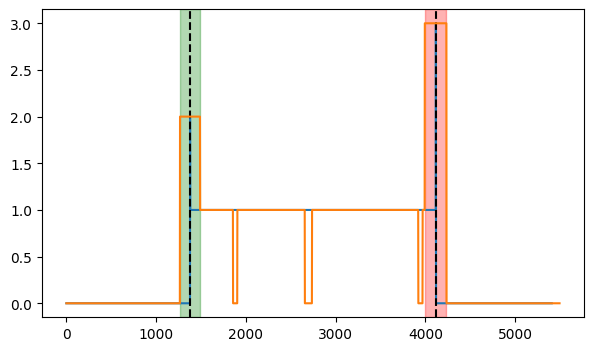

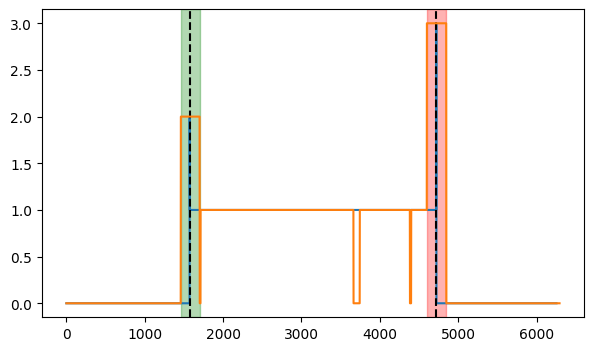

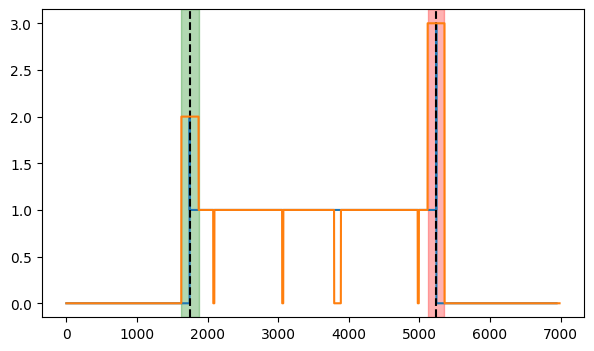

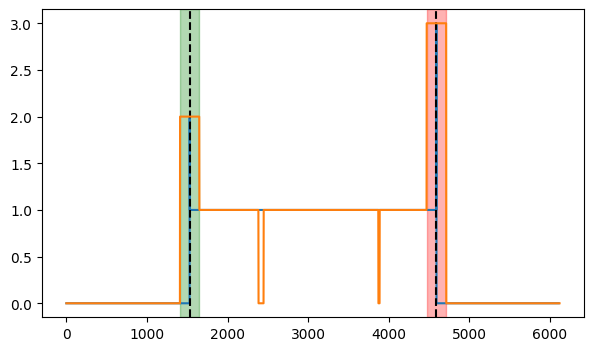

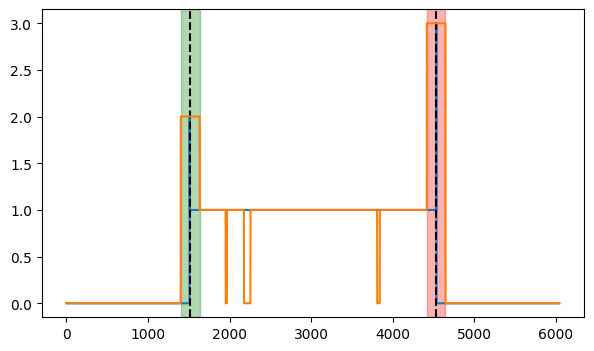

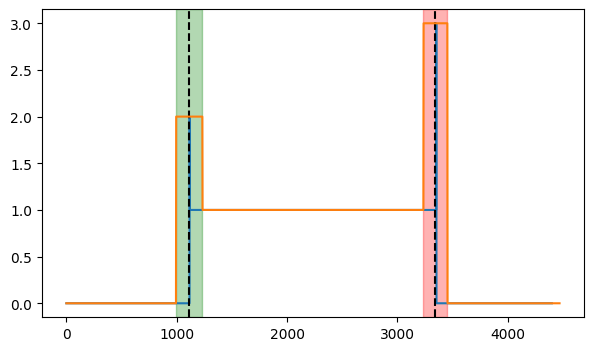

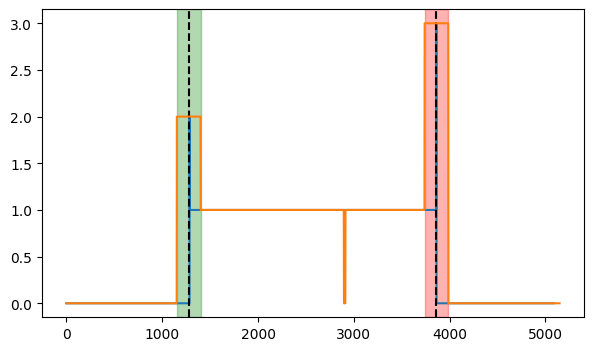

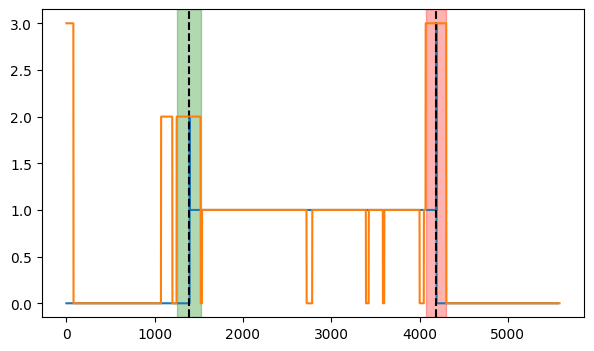

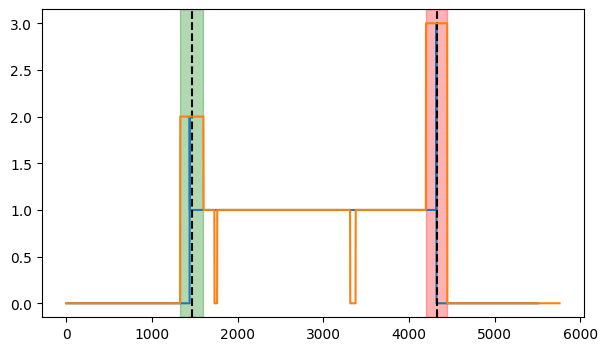

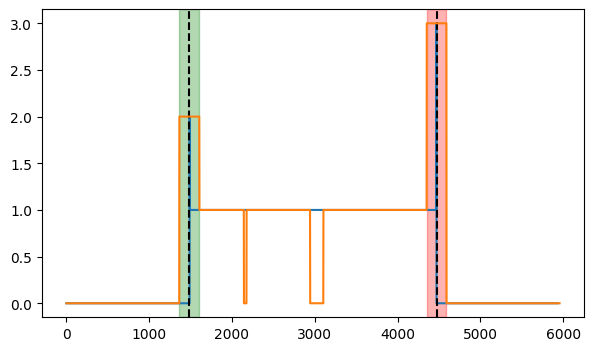

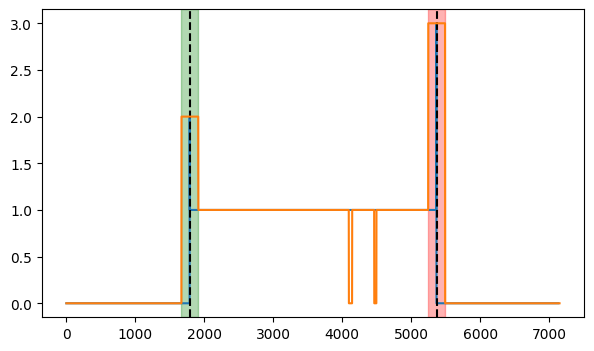

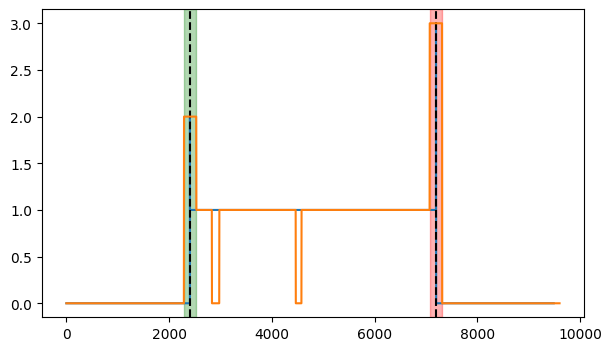

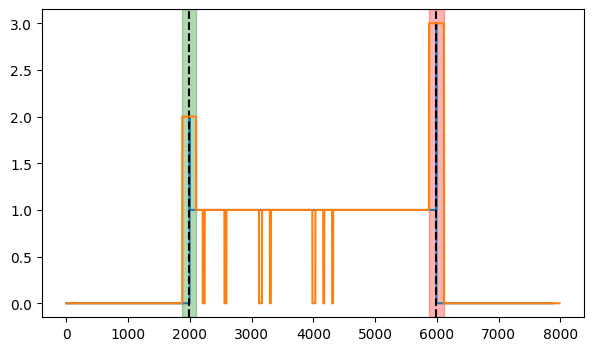

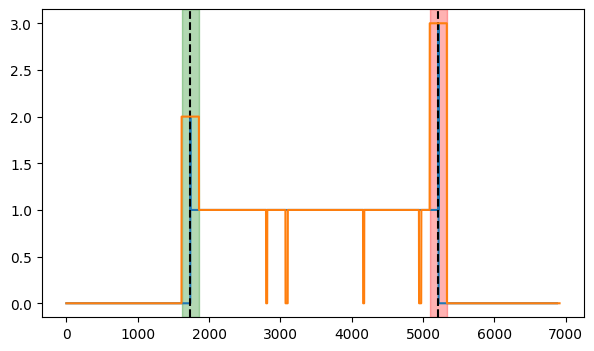

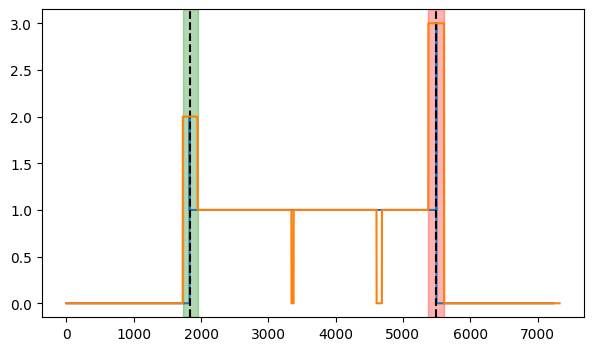

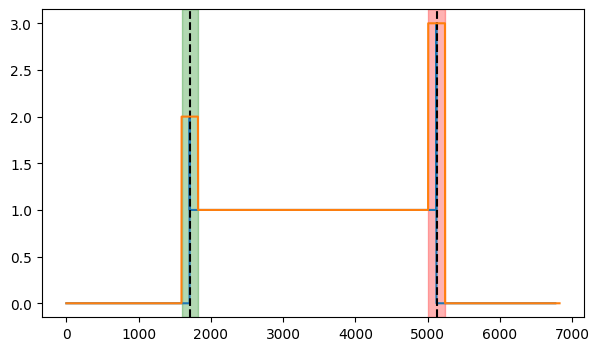

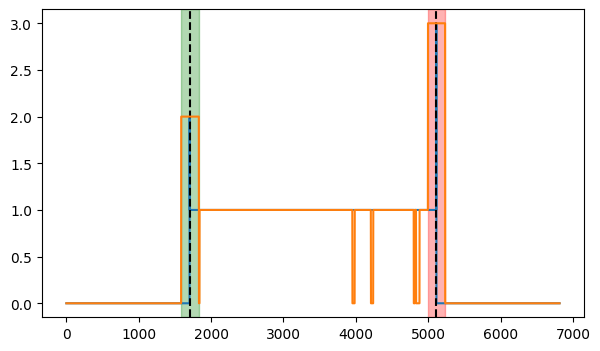

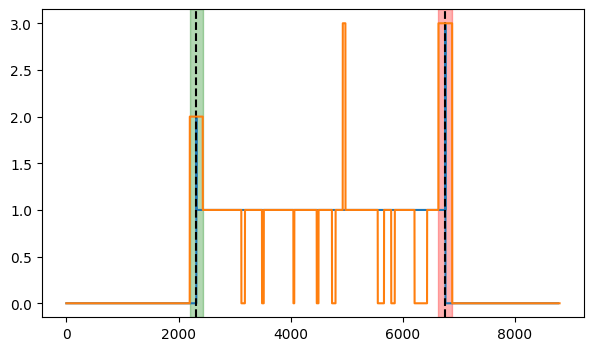

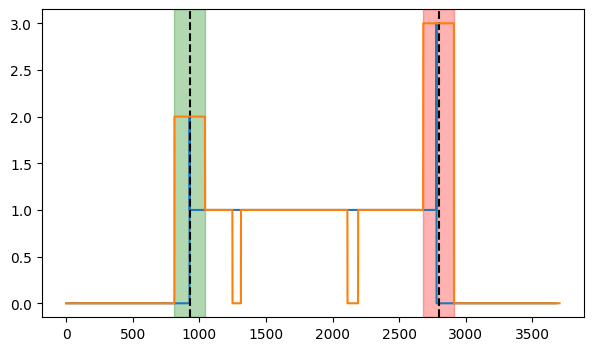

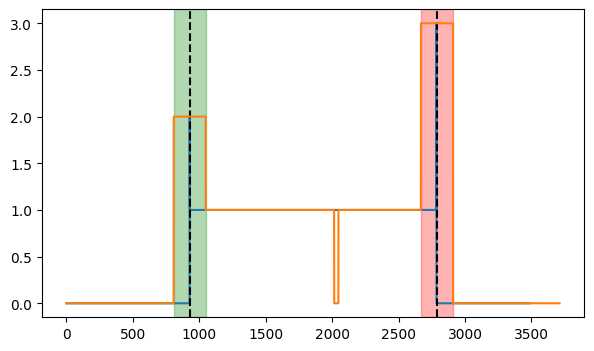

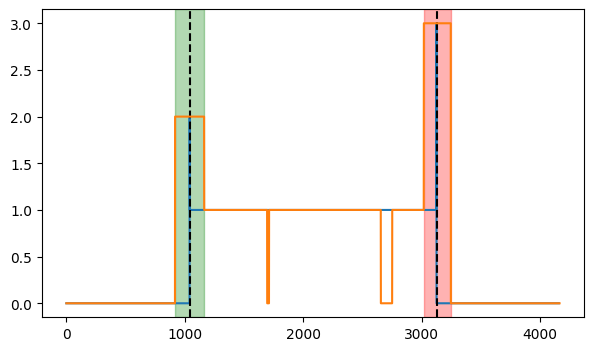

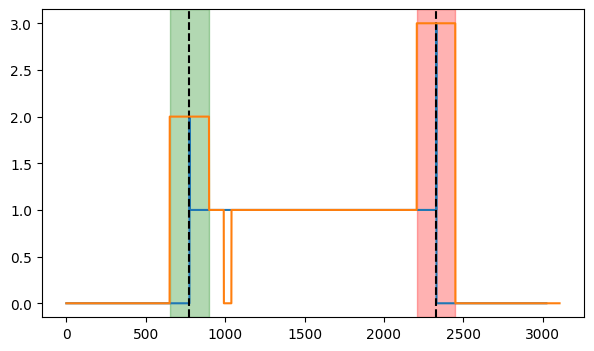

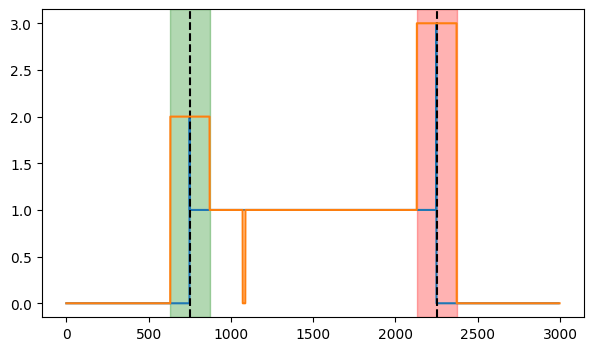

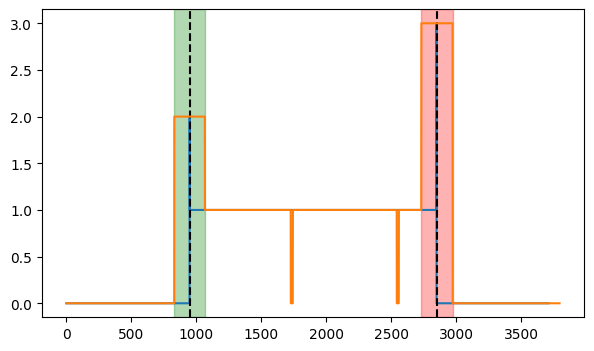

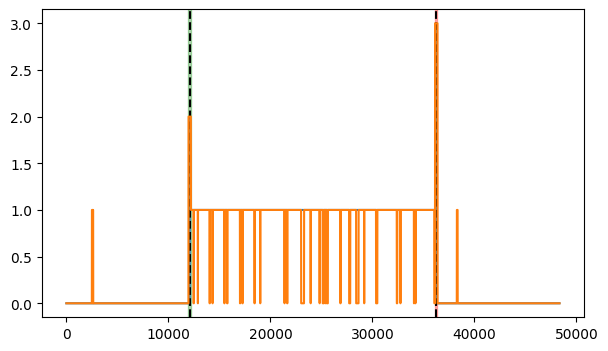

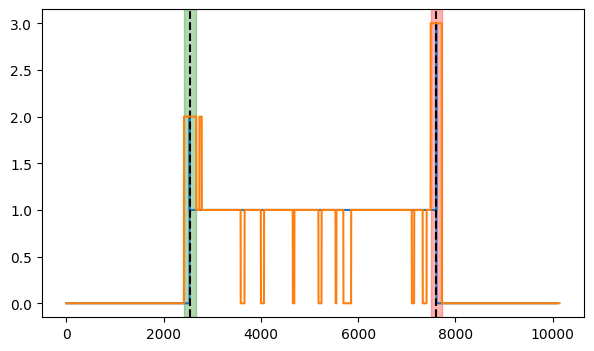

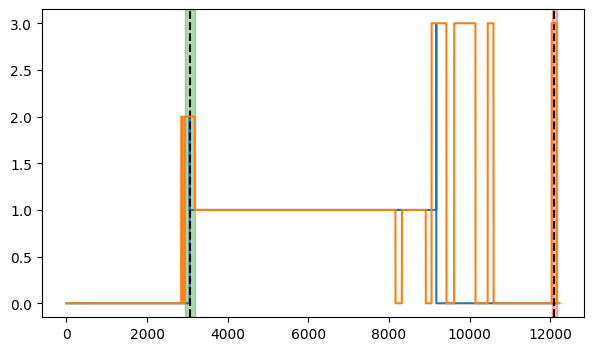

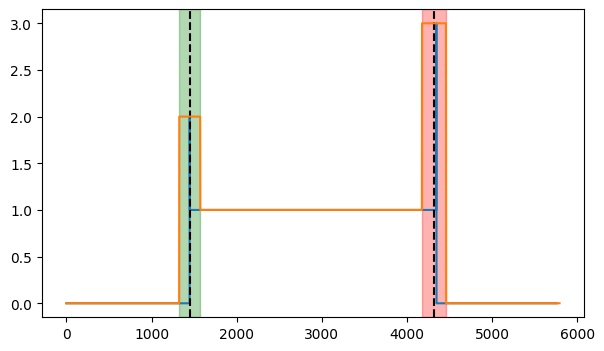

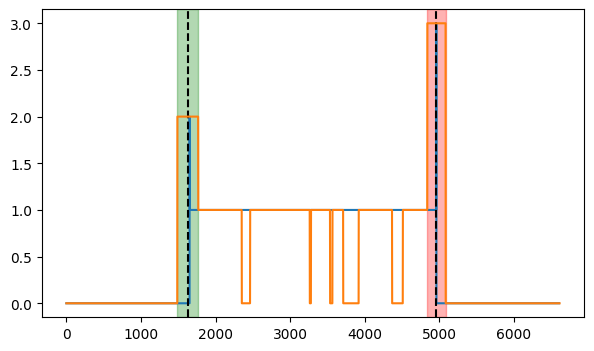

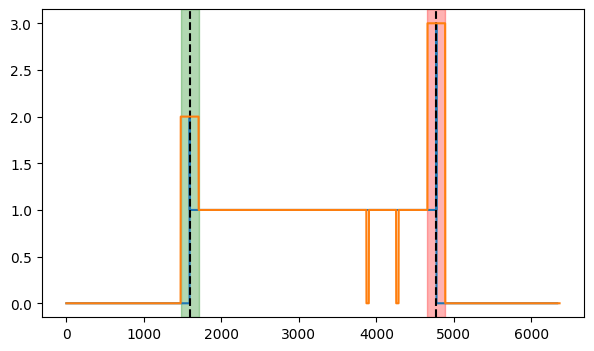

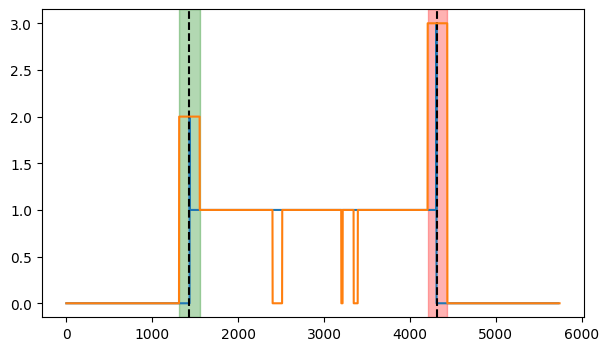

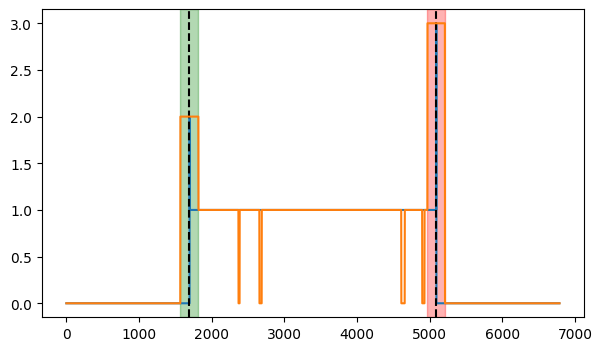

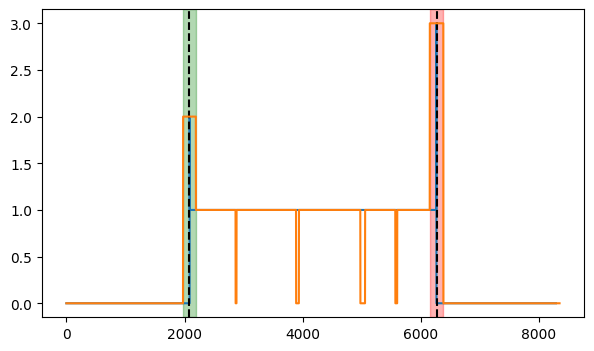

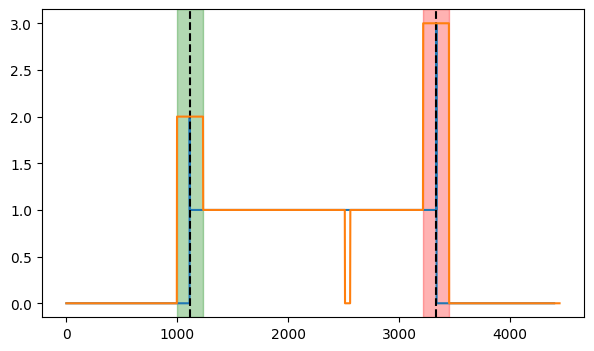

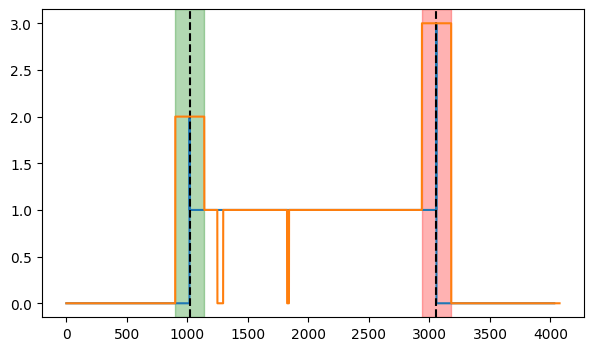

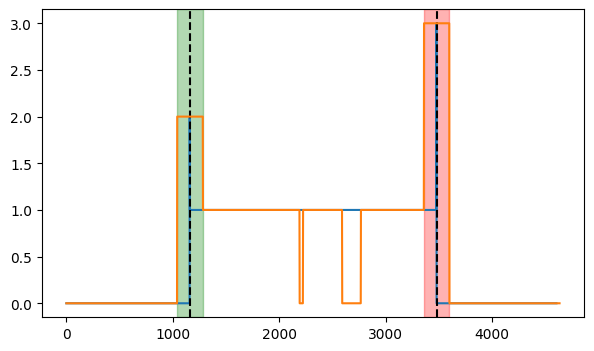

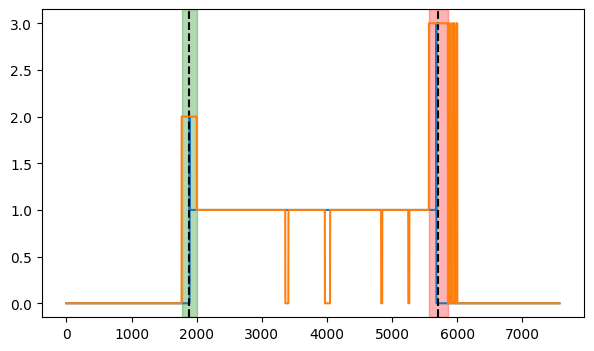

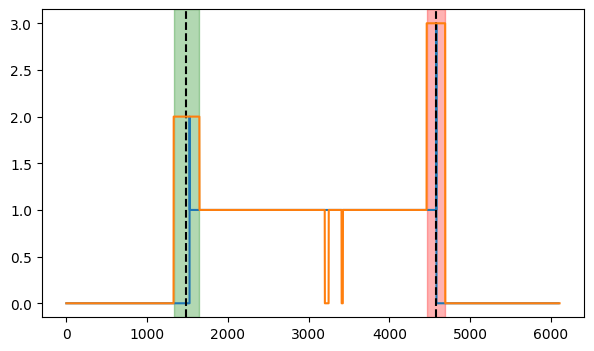

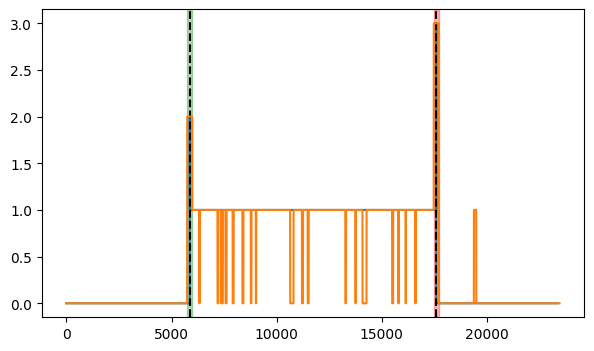

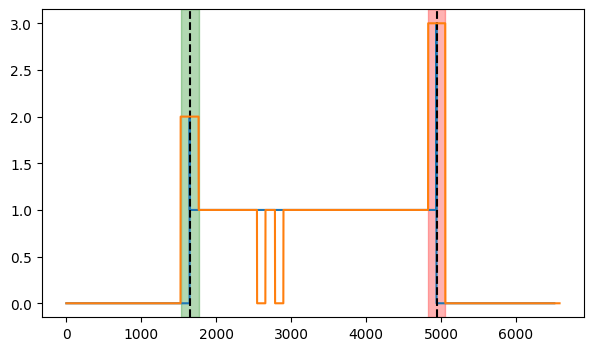

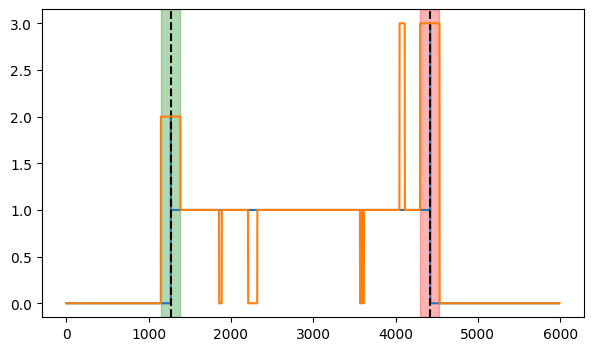

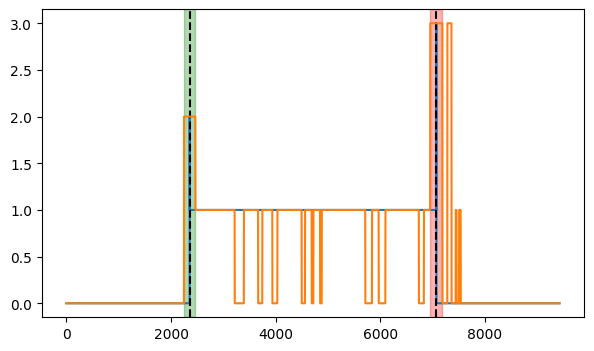

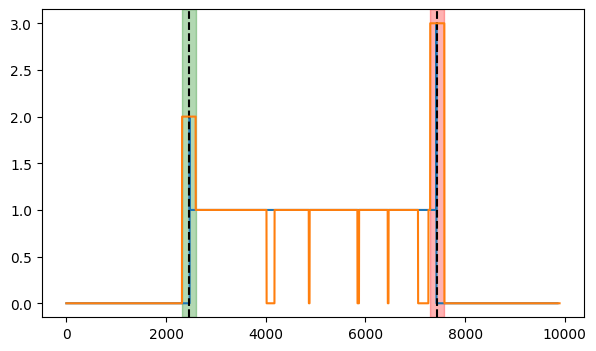

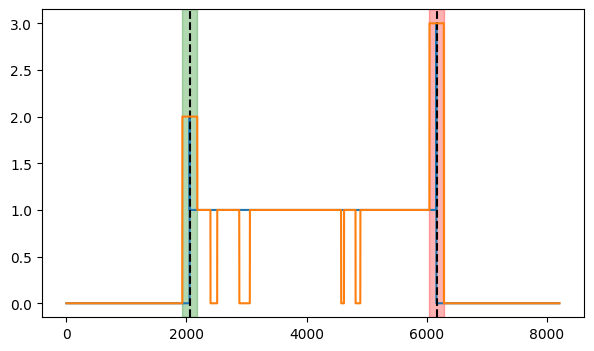

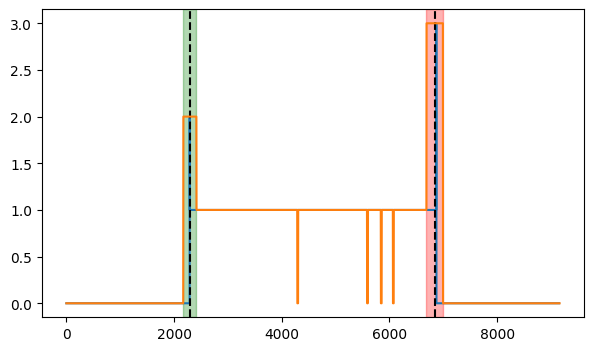

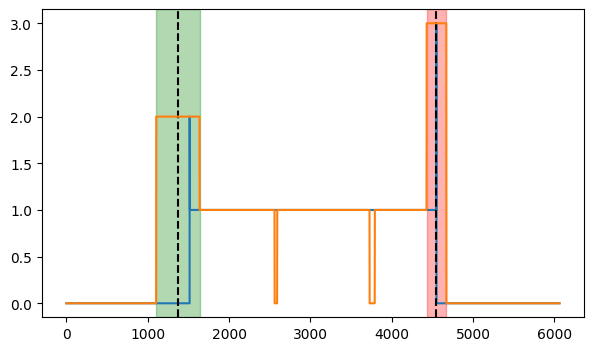

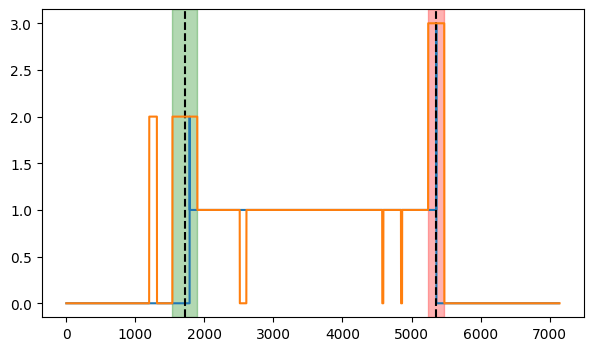

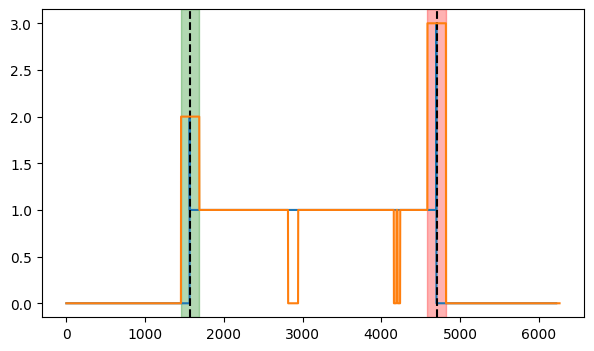

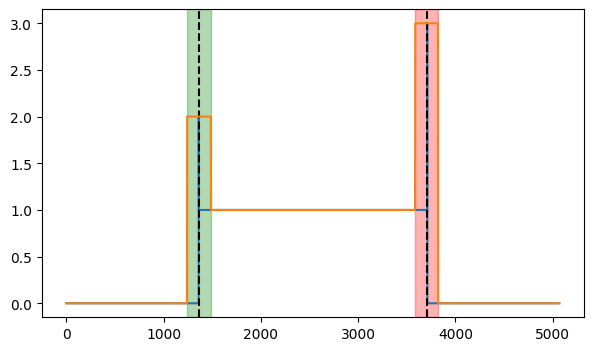

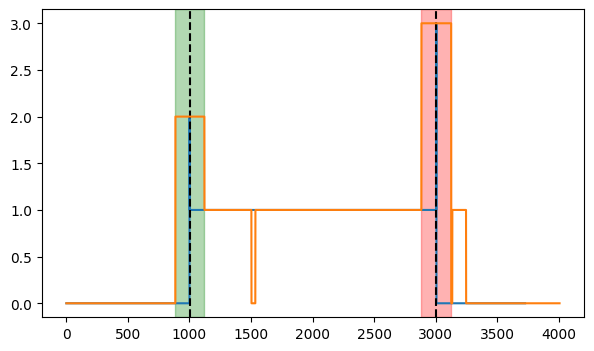

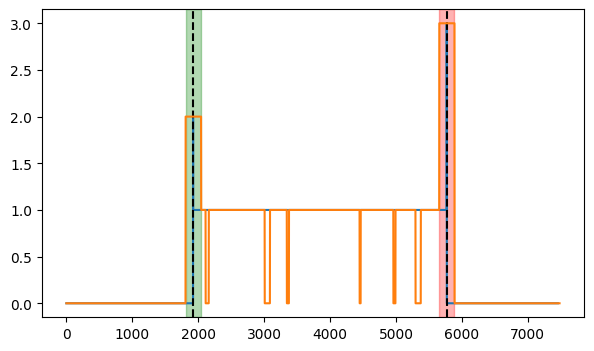

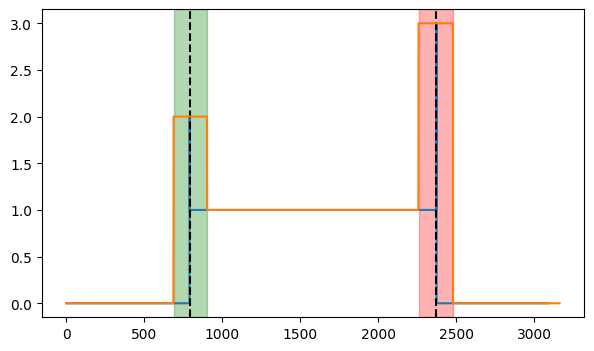

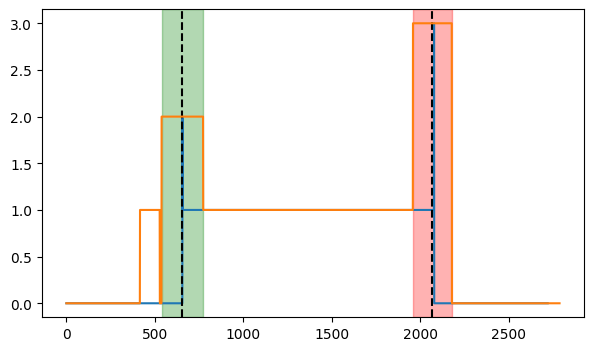

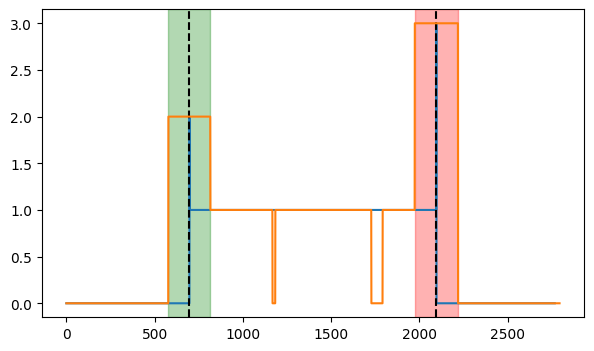

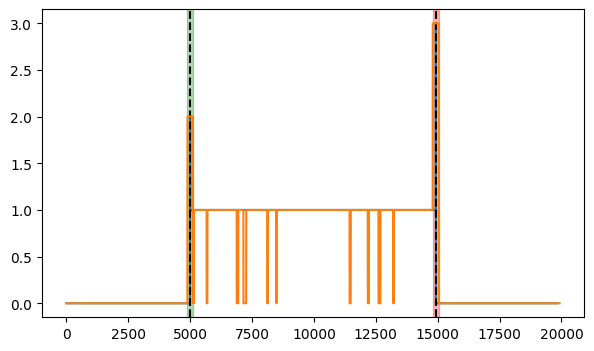

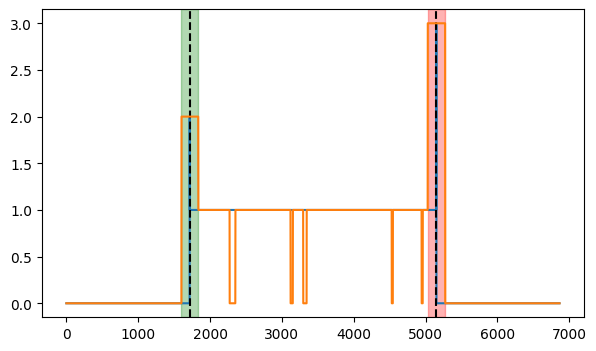

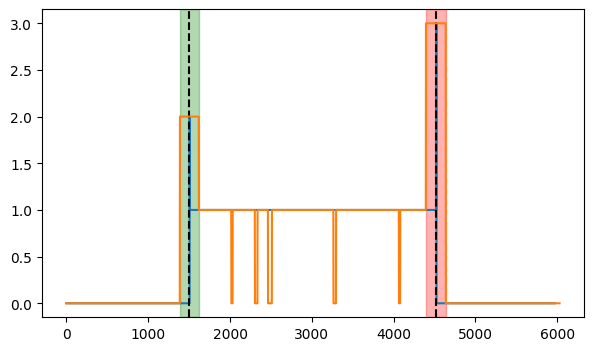

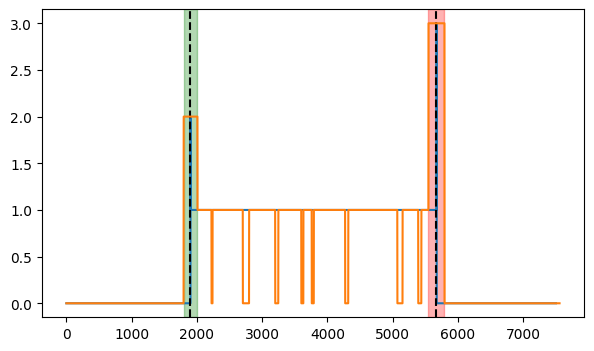

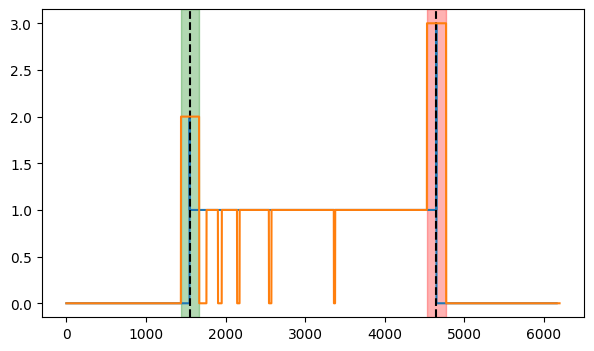

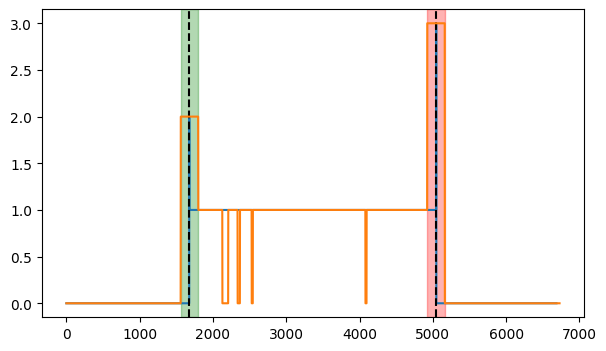

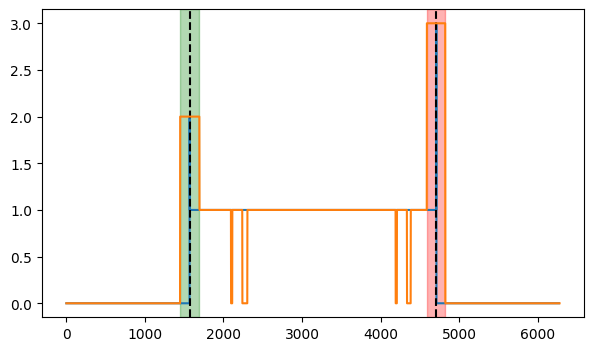

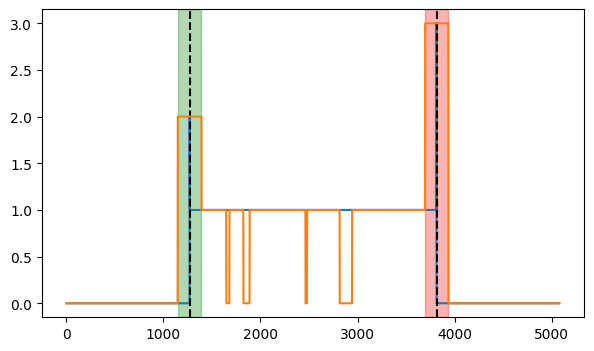

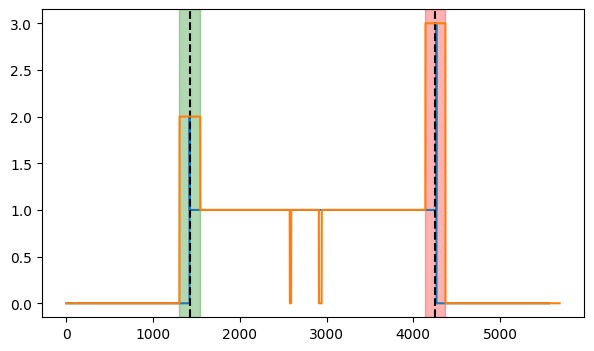

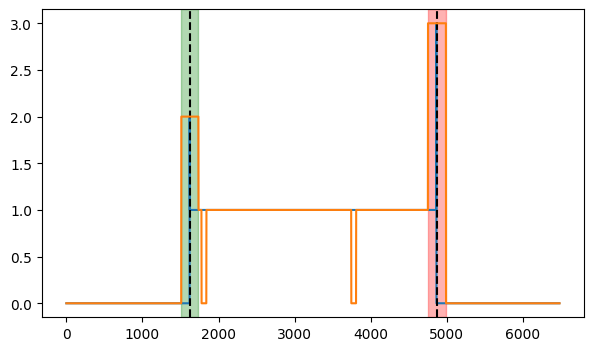

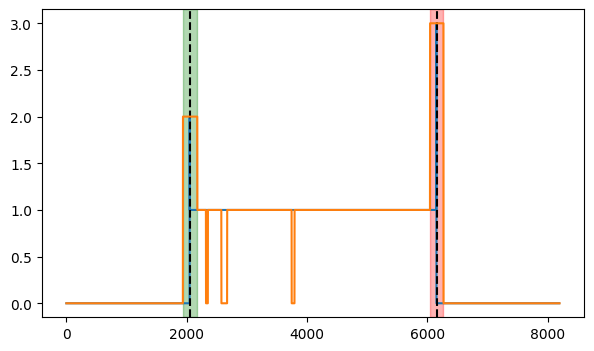

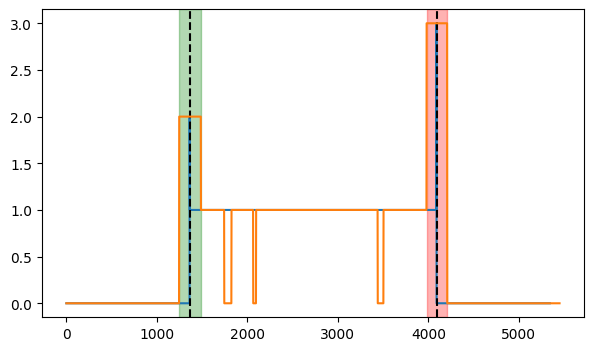

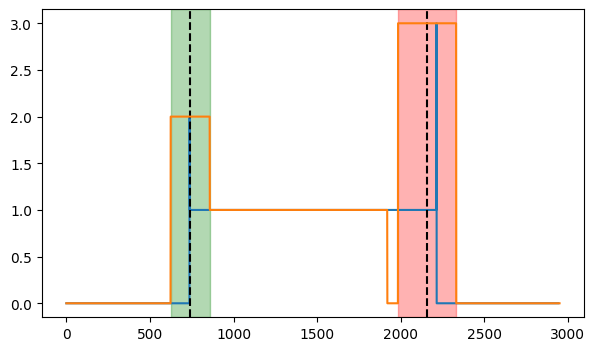

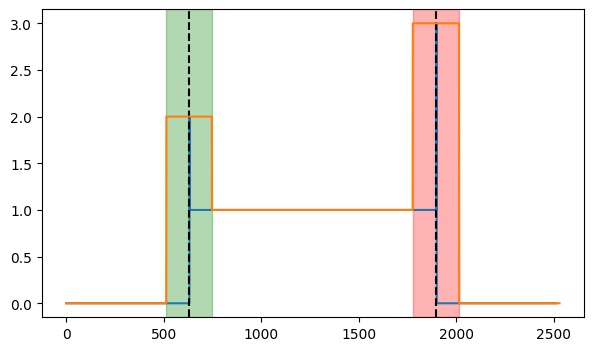

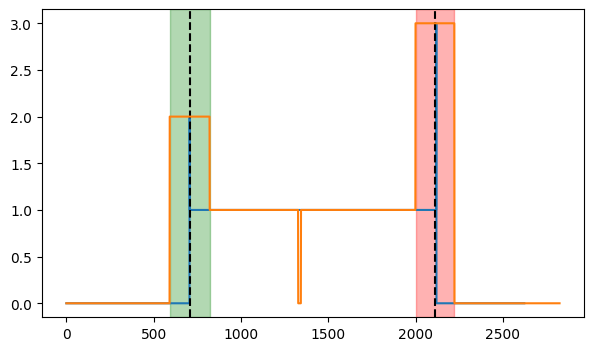

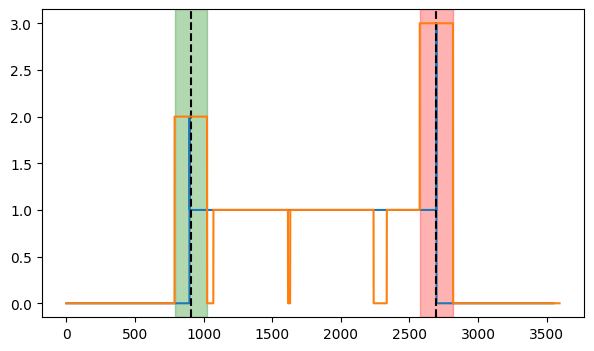

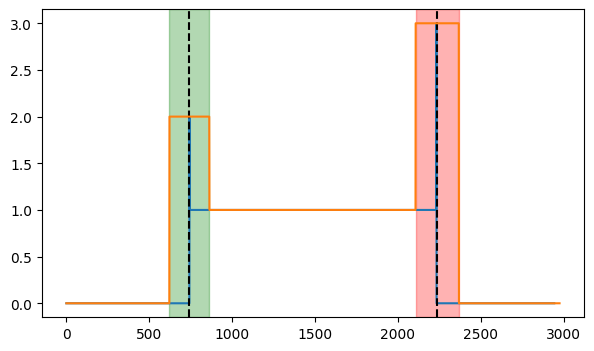

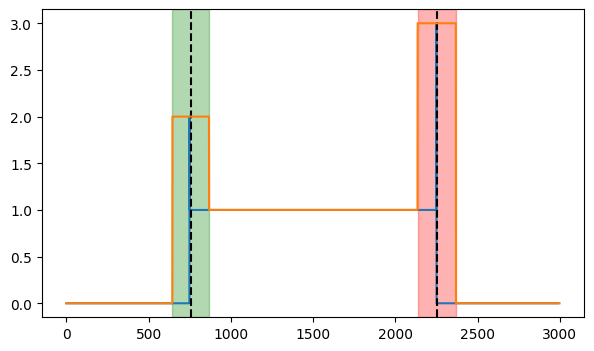

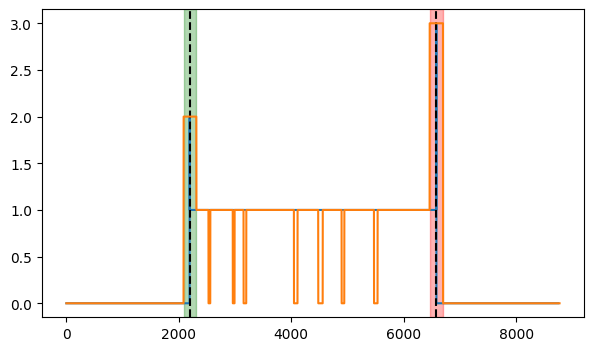

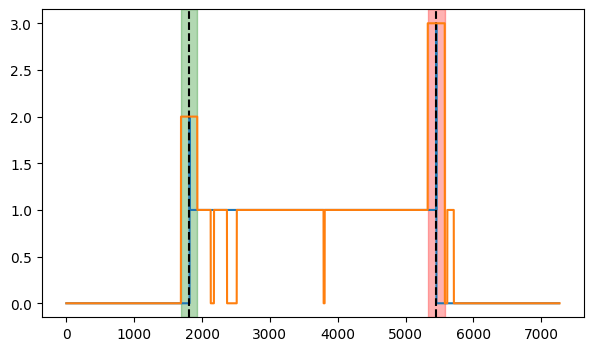

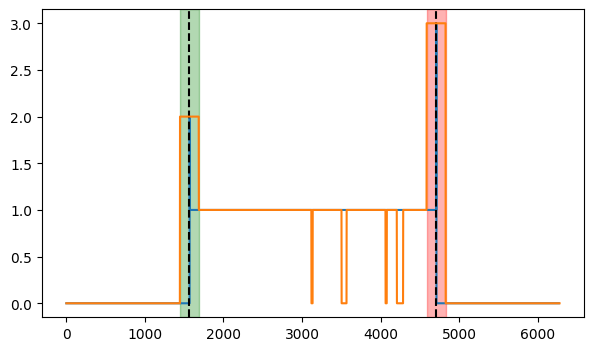

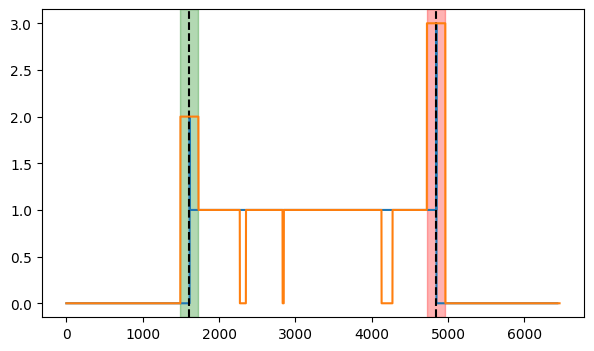

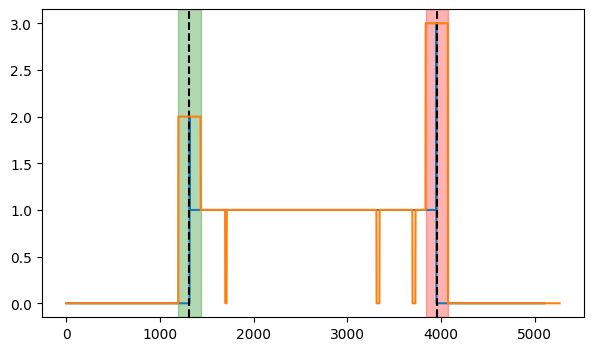

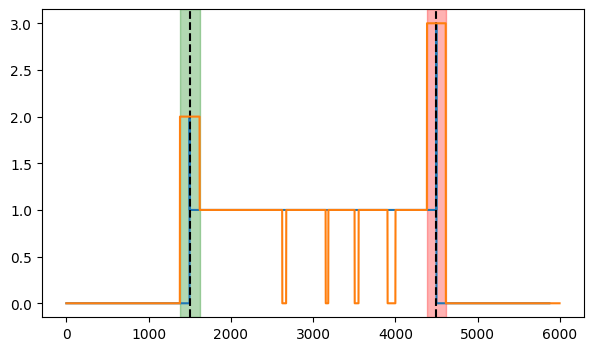

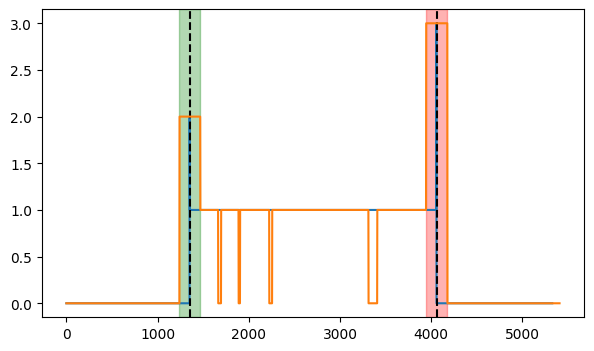

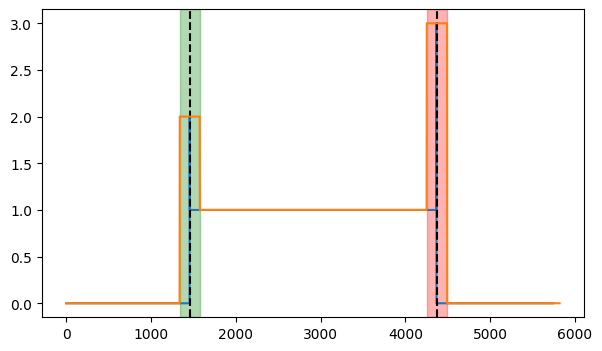

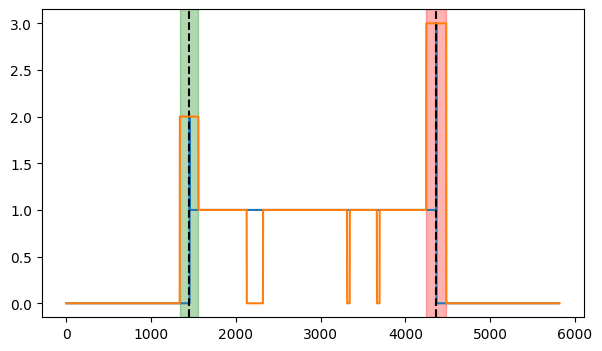

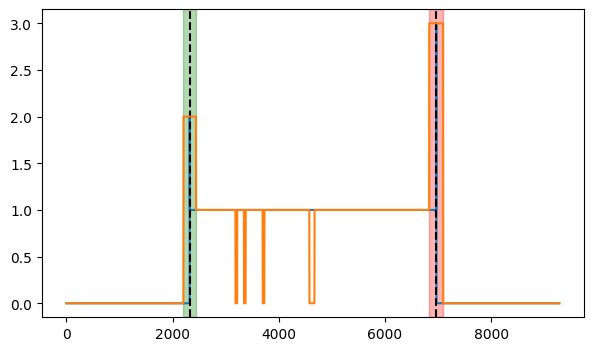

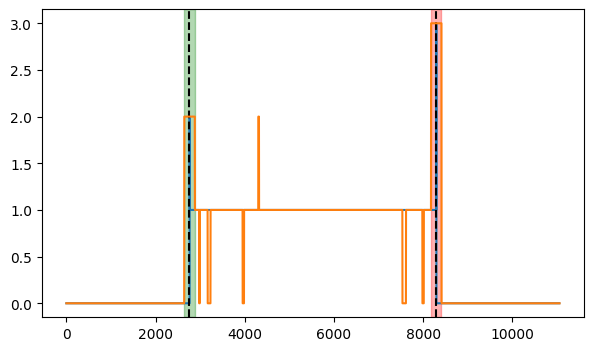

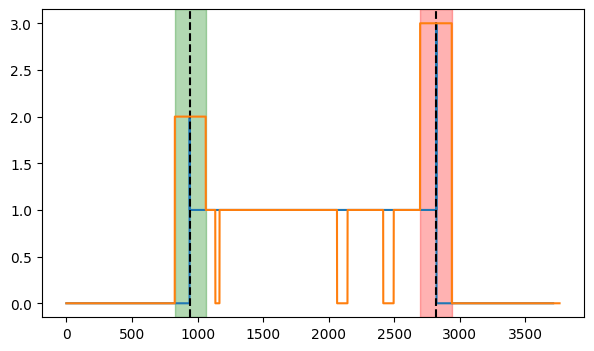

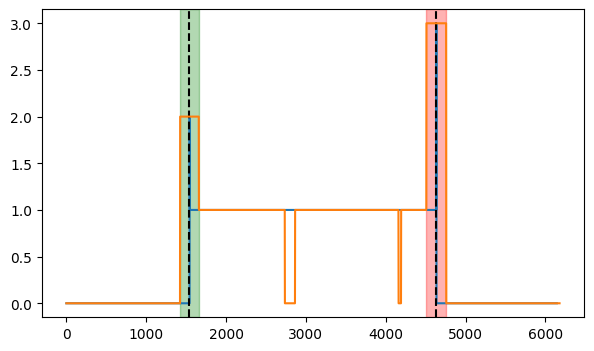

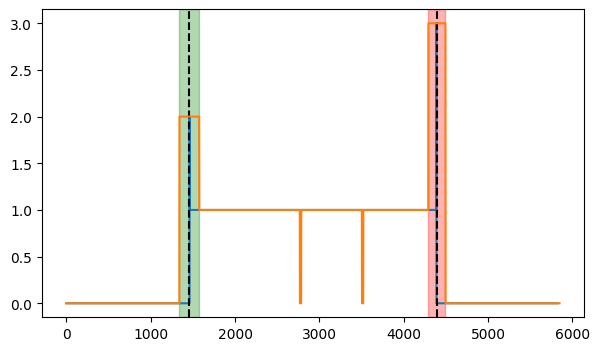

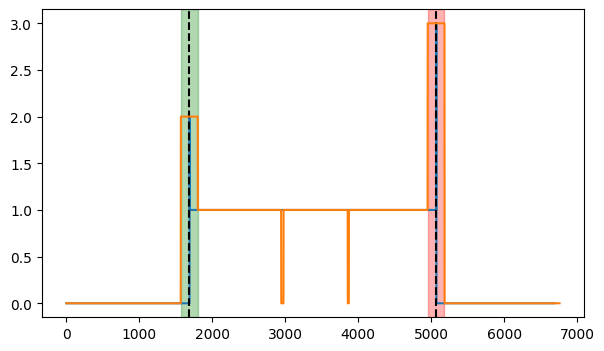

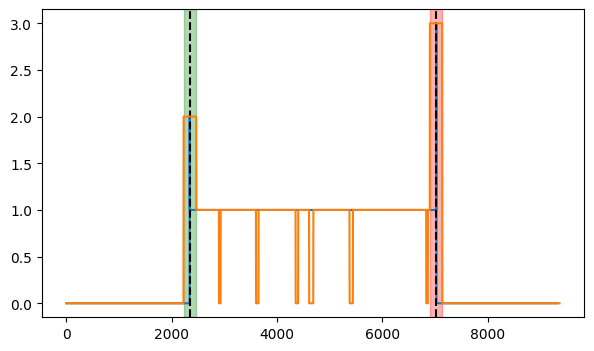

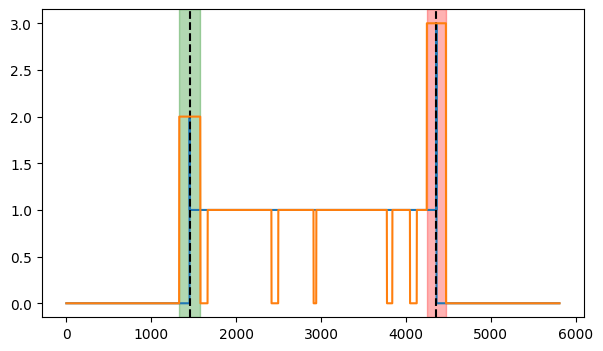

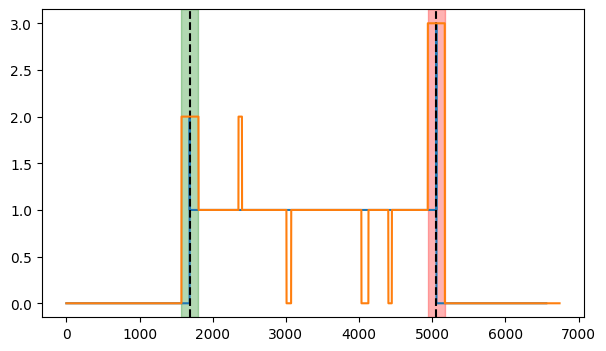

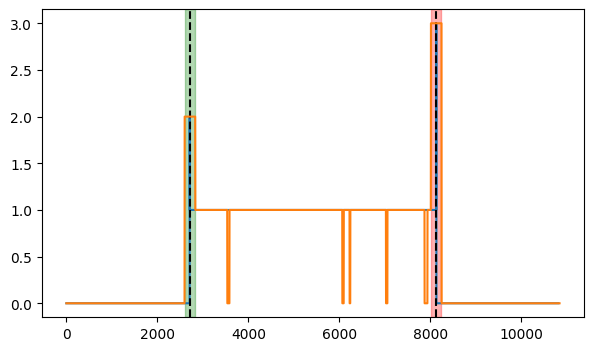

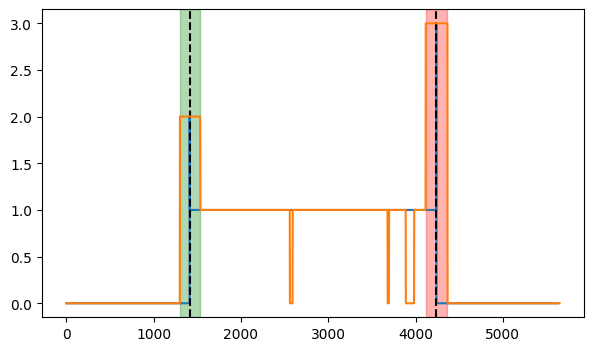

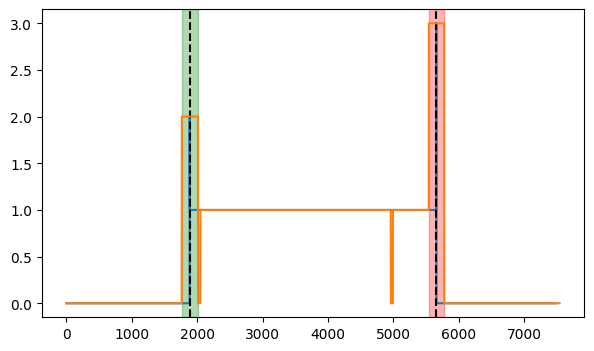

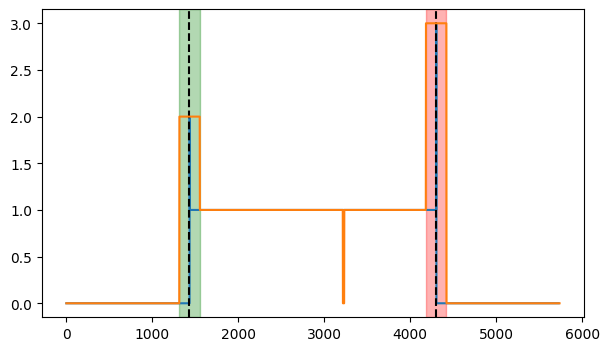

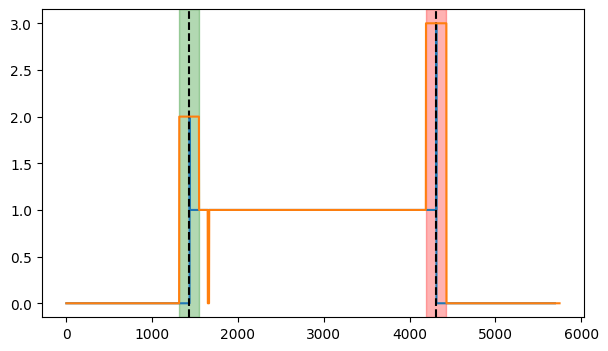

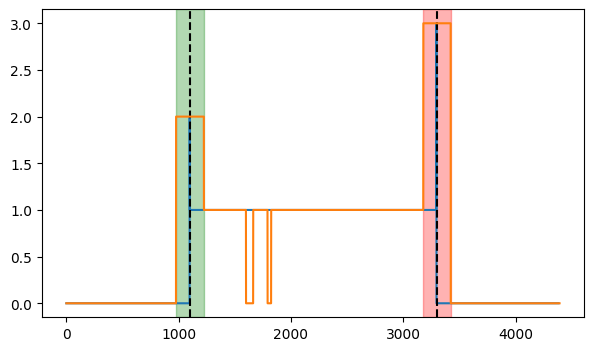

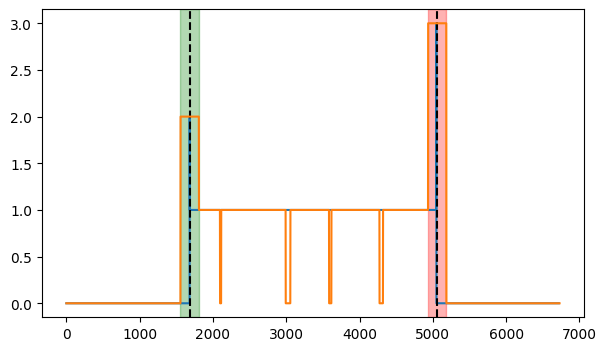

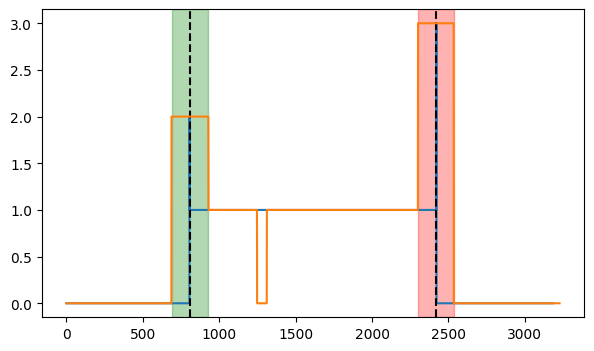

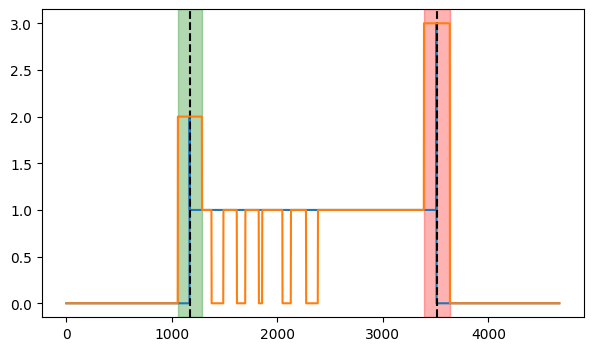

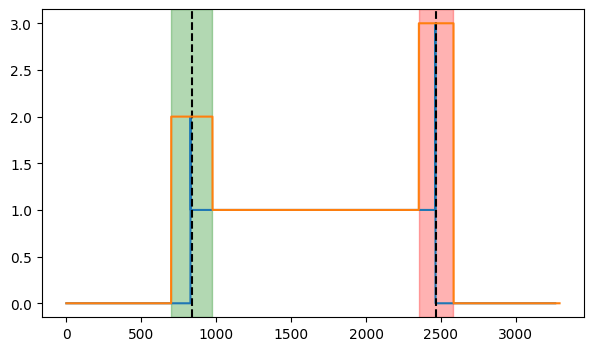

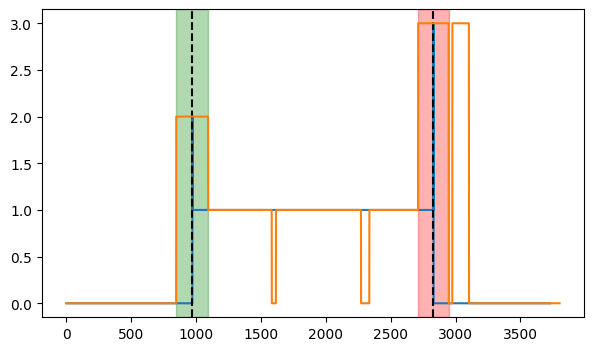

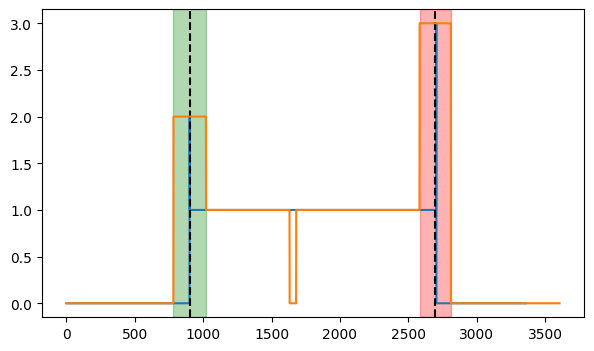

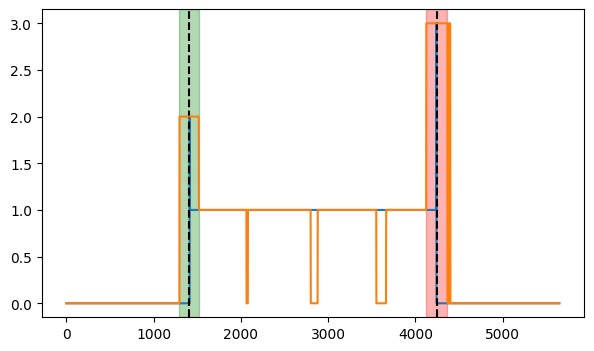

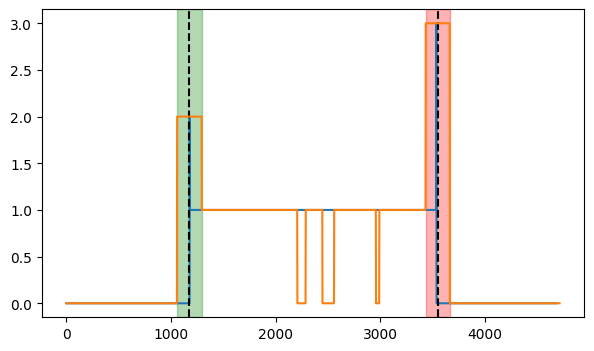

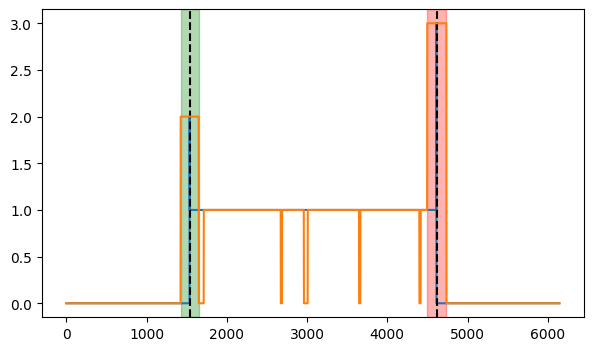

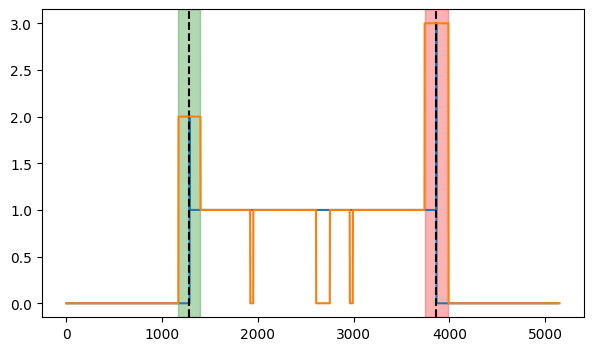

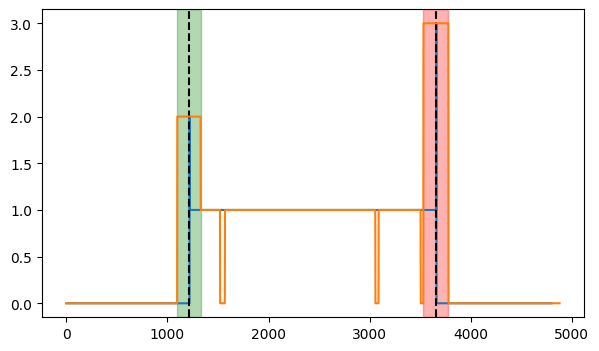

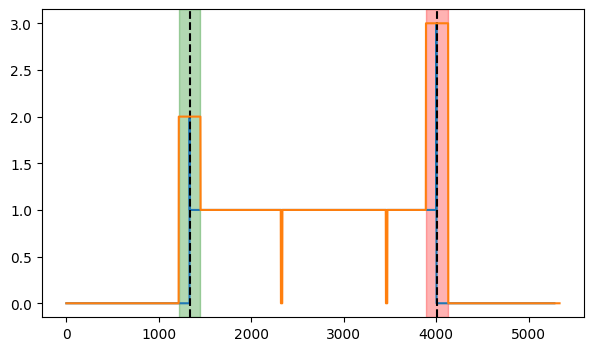

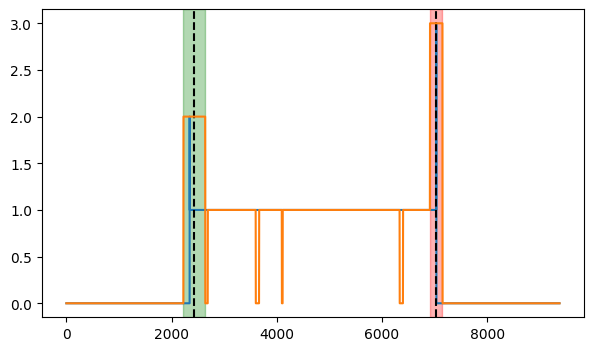

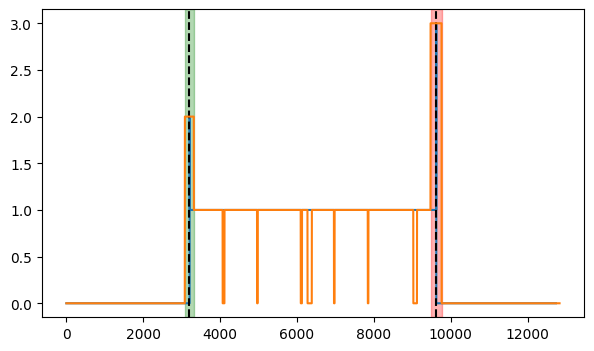

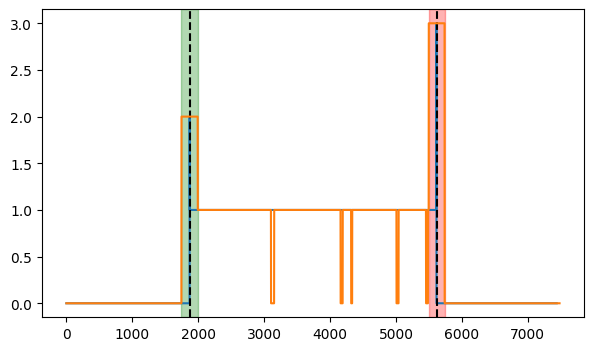

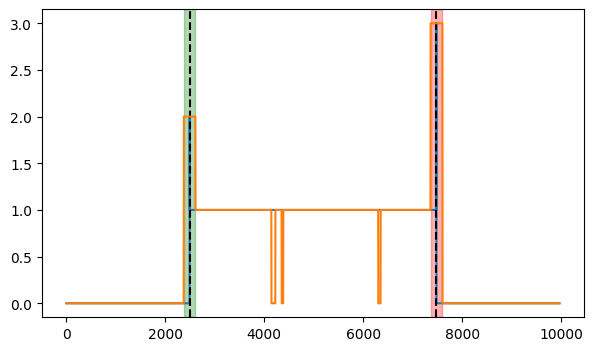

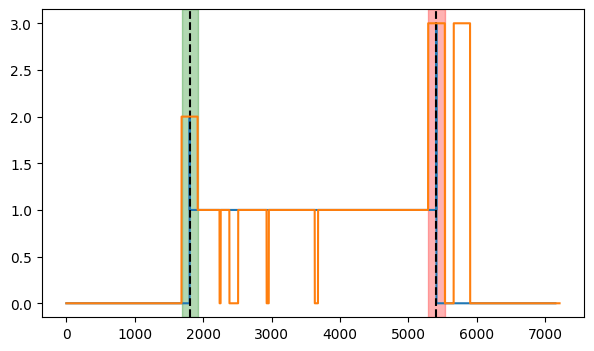

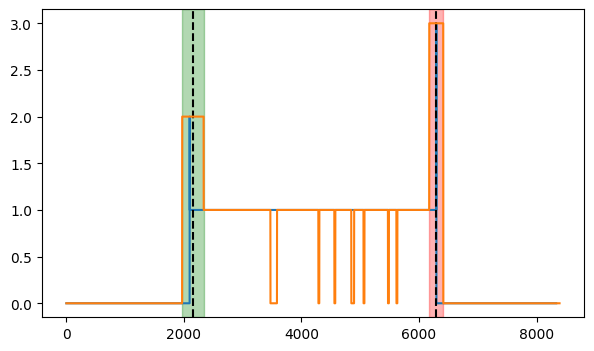

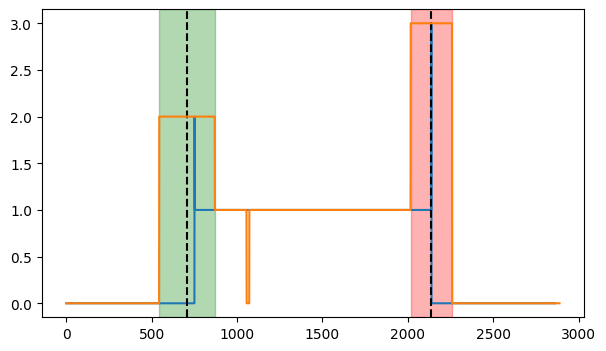

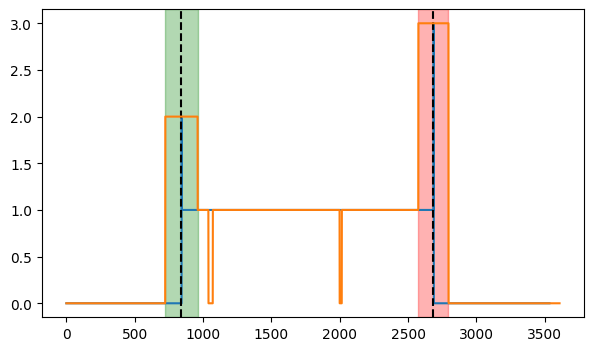

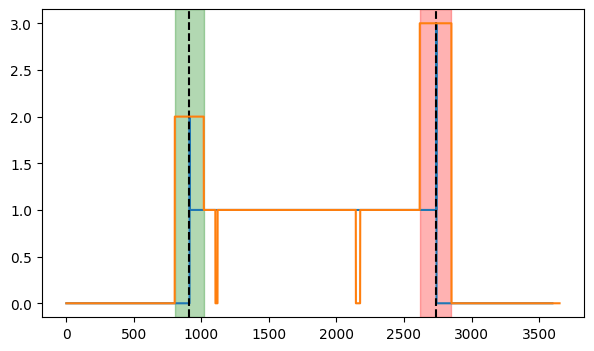

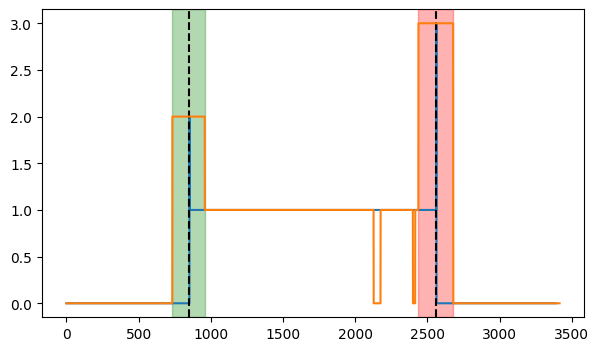

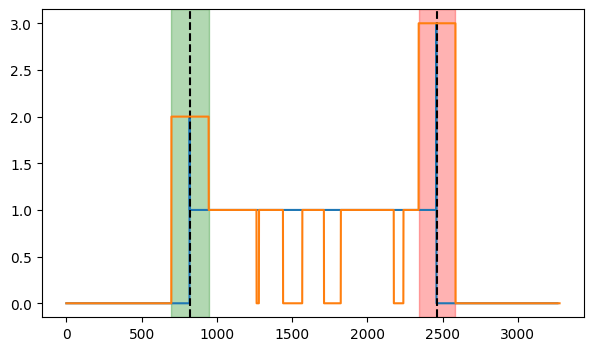

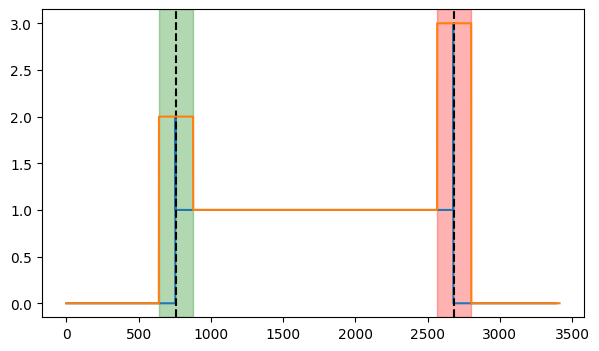

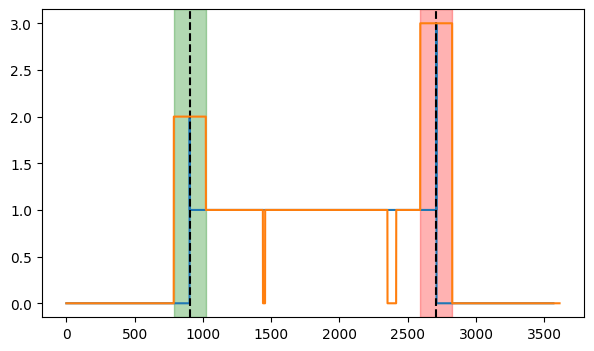

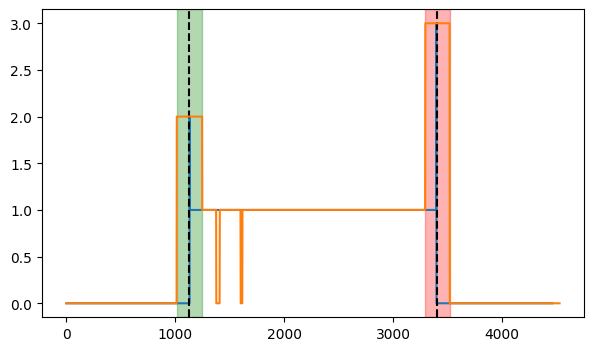

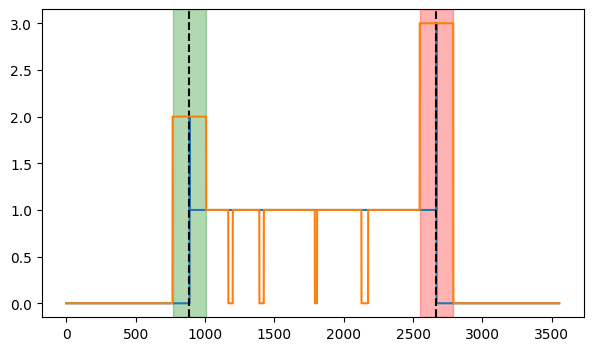

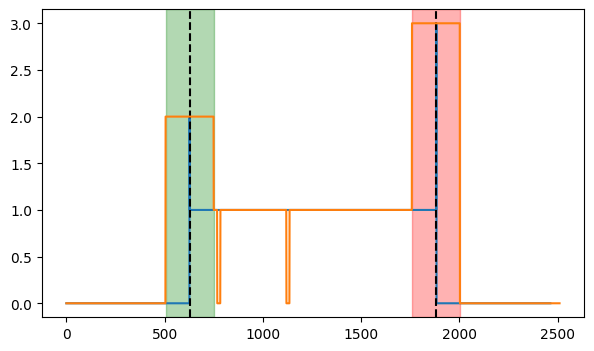

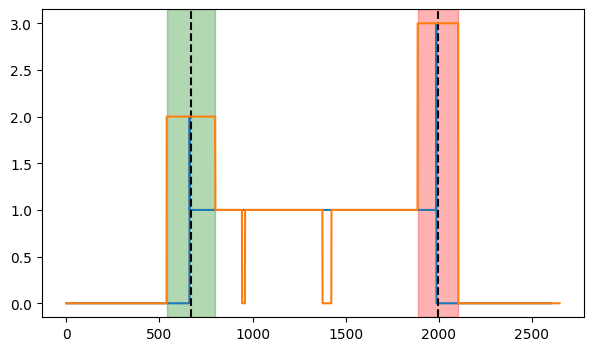

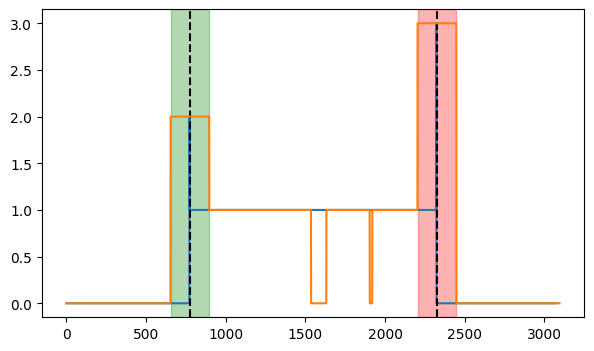

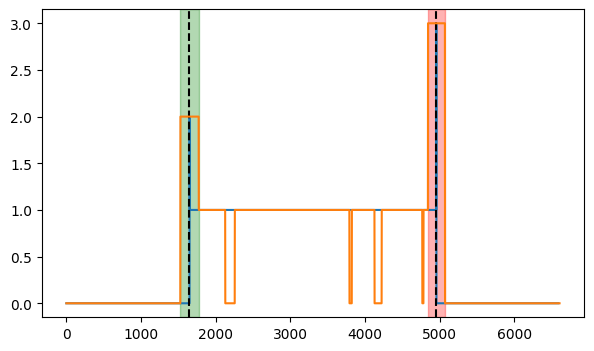

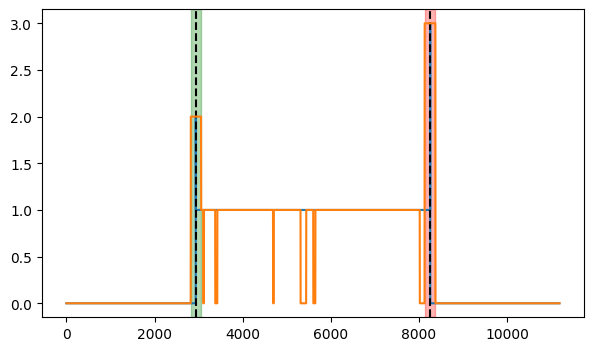

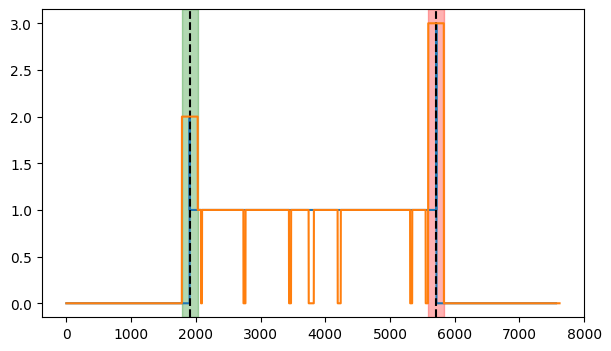

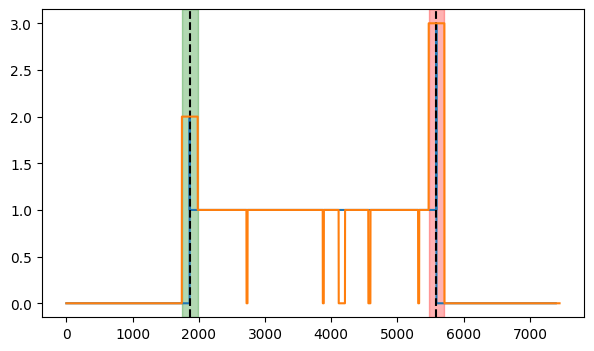

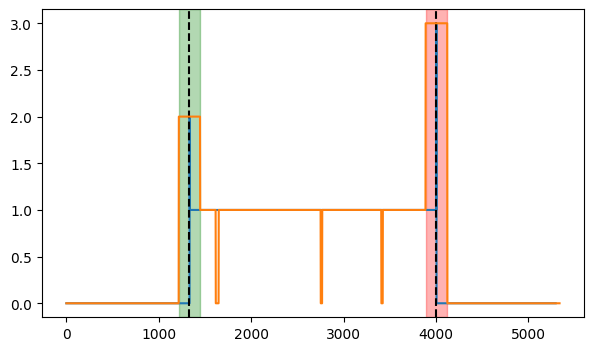

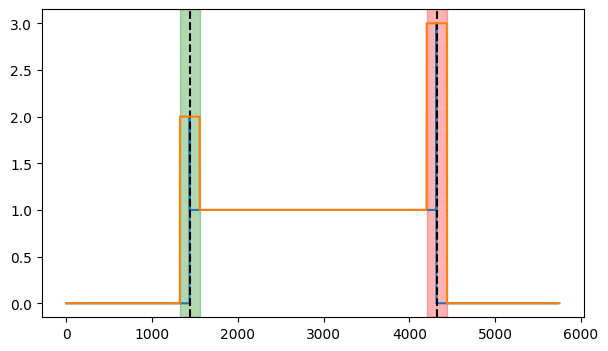

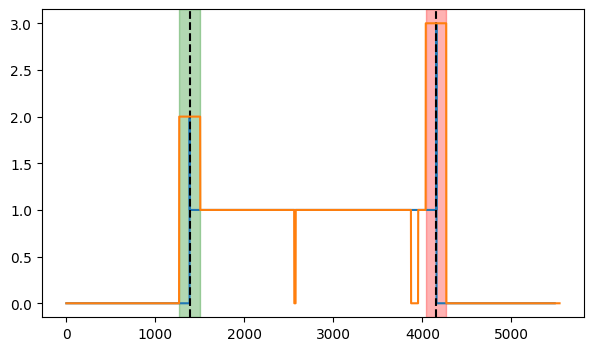

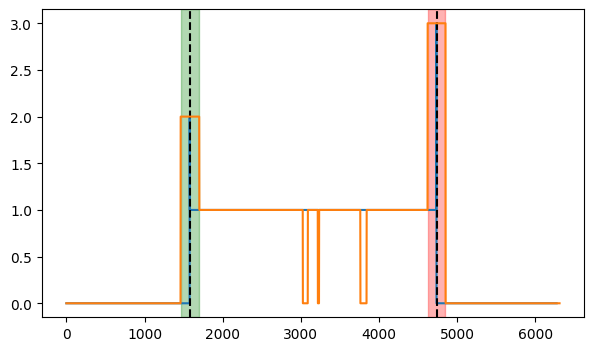

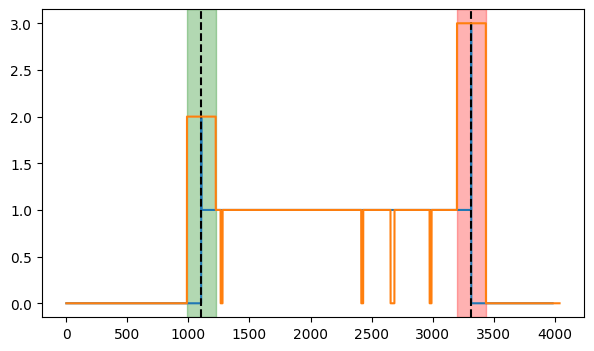

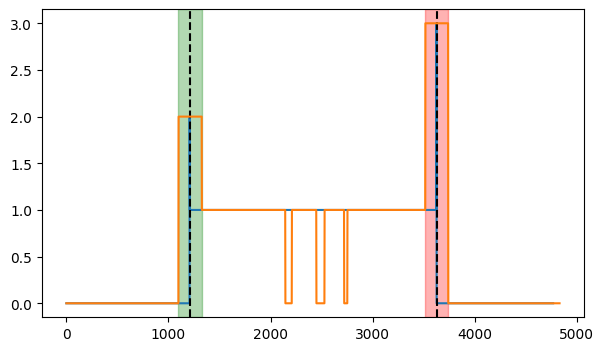

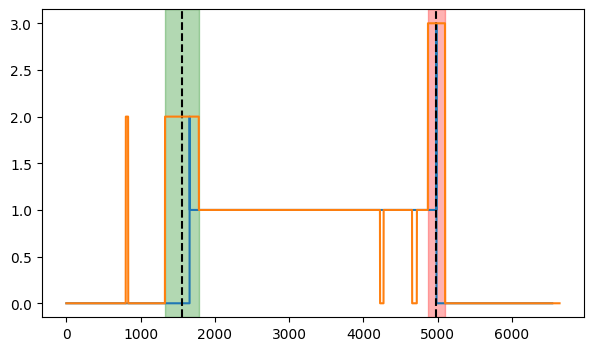

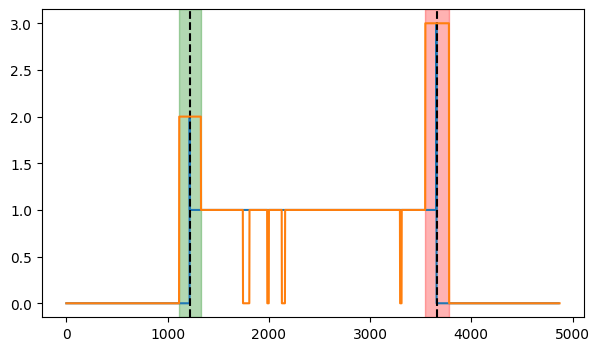

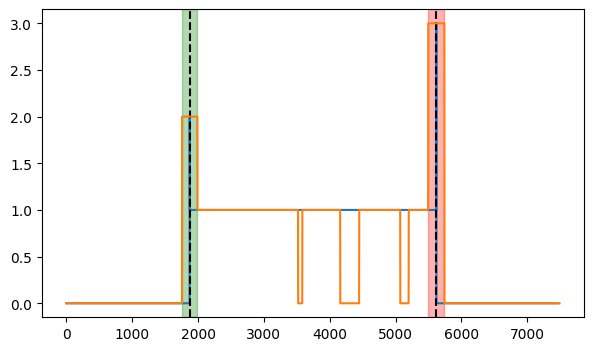

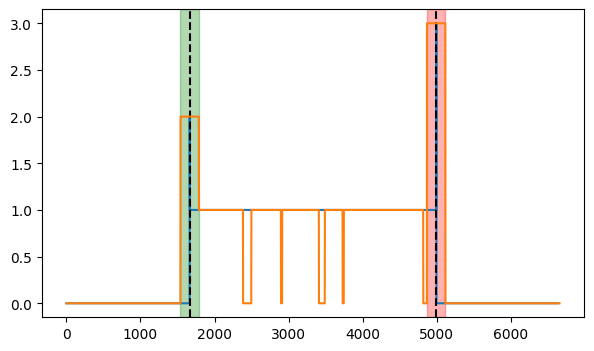

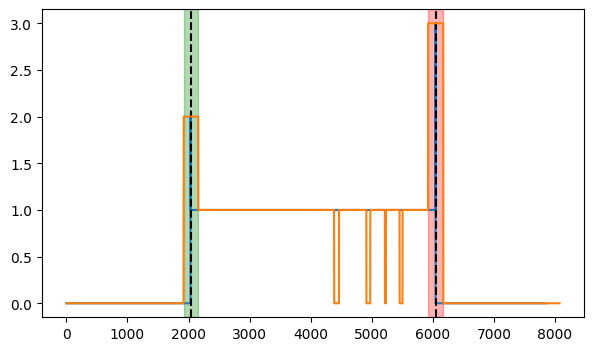

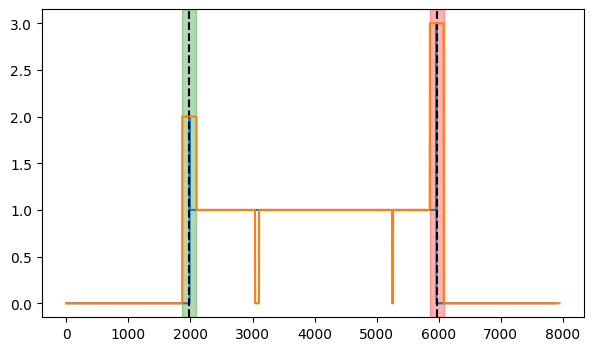

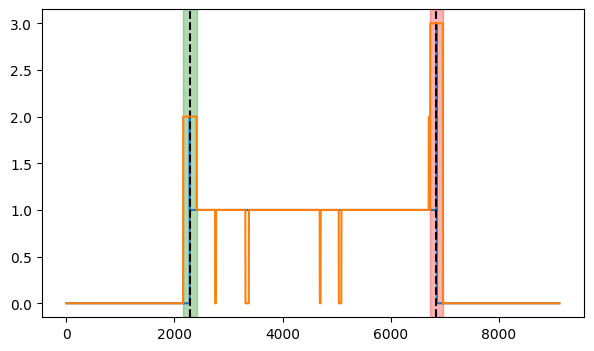

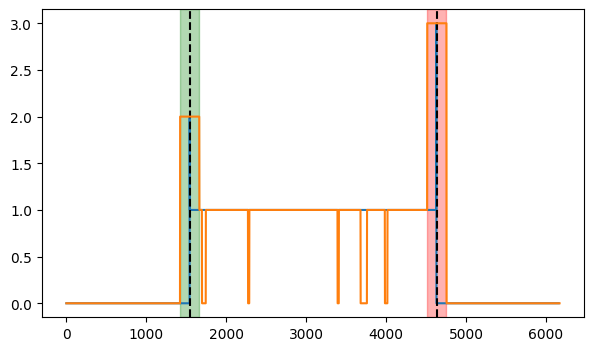

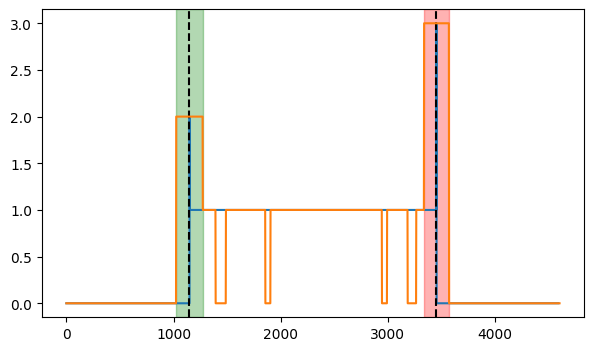

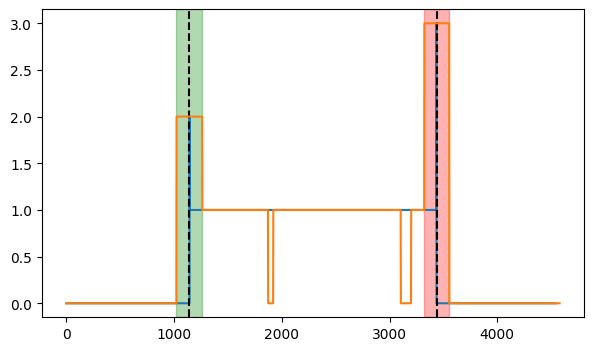

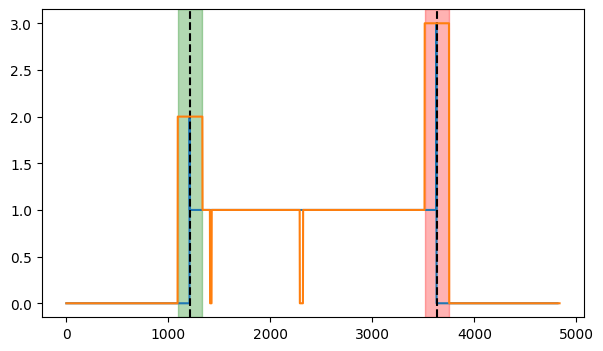

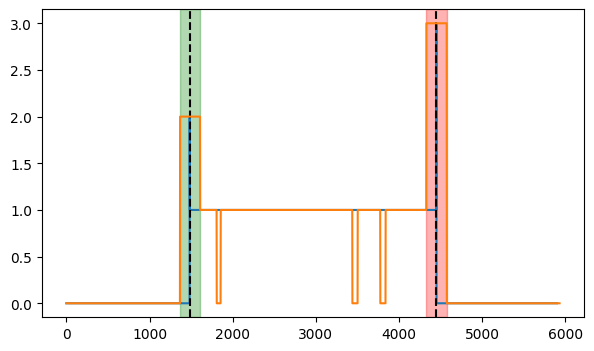

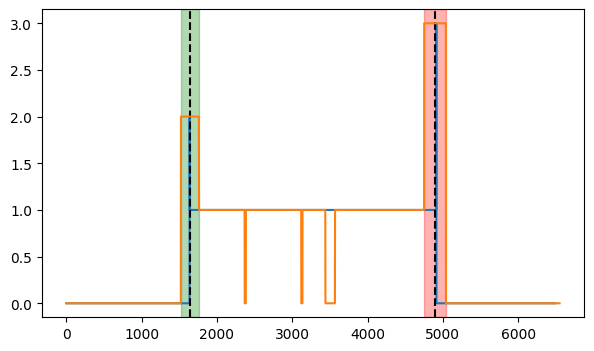

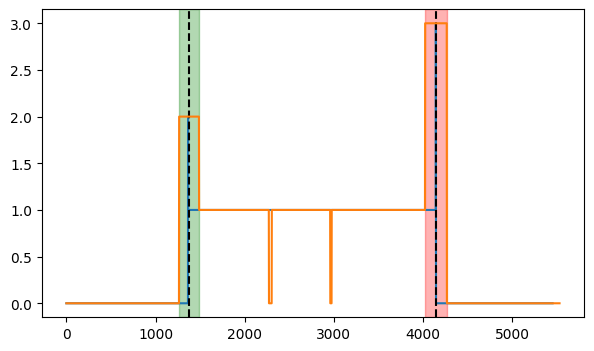

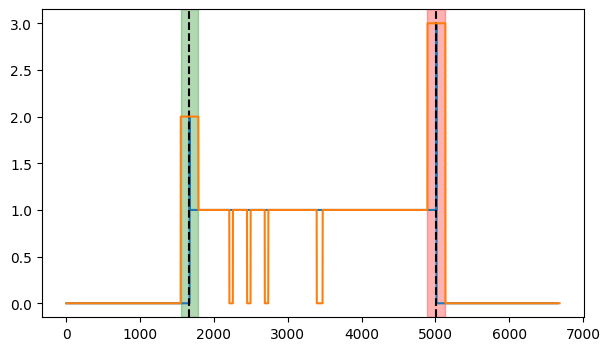

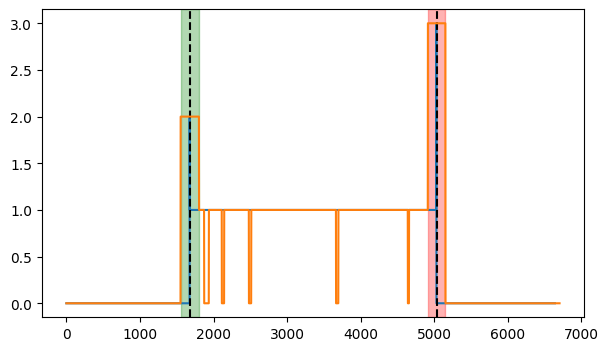

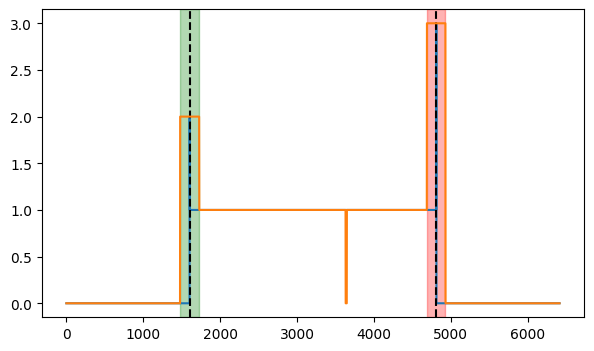

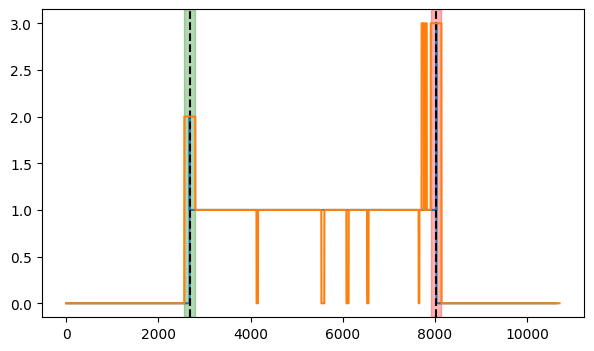

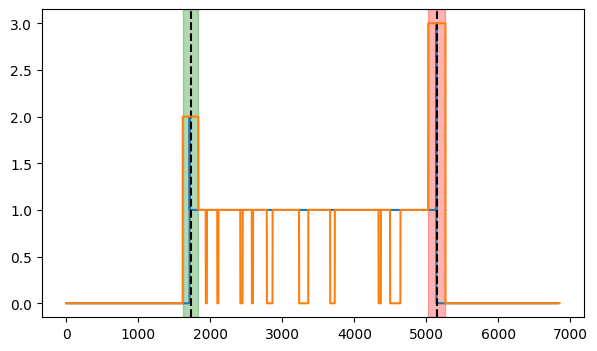

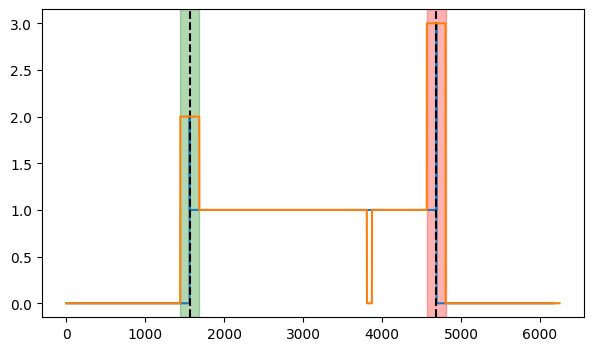

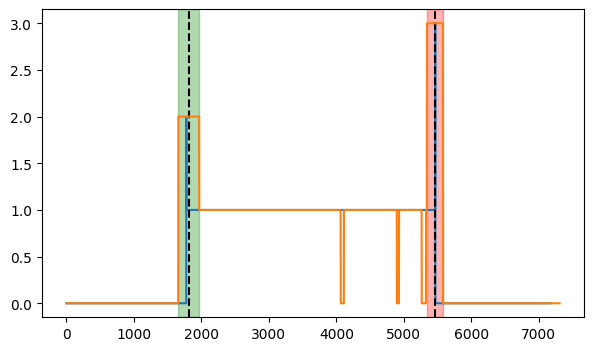

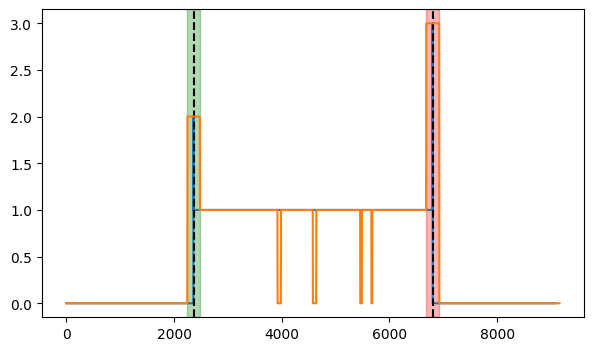

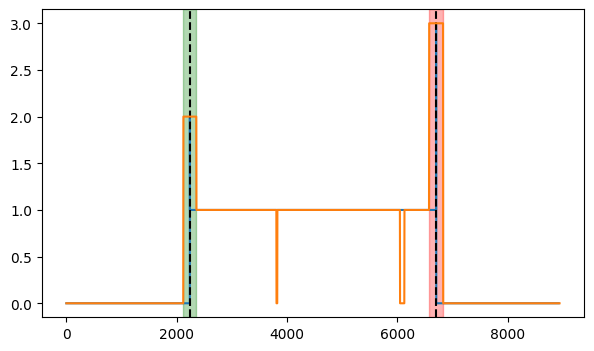

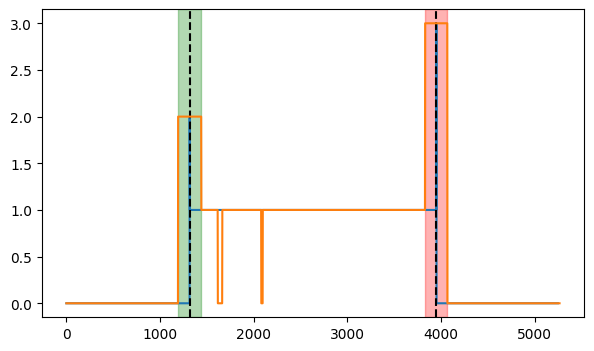

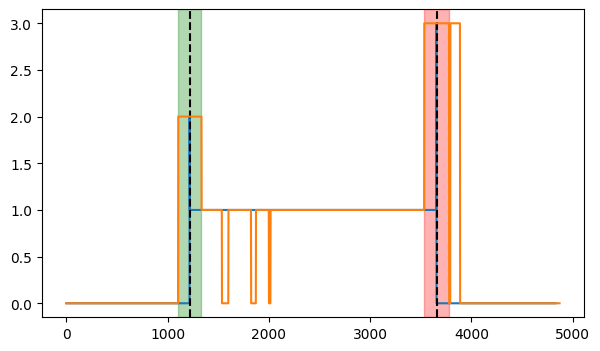

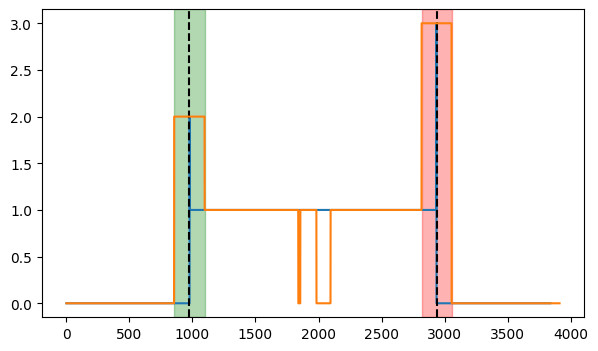

In [ ]:
# Architecture 2

X_test = np.load('X_test.npy')
Y_test = np.load('Y_test.npy')
trialIDs_test = np.load('trial_ids_test.npy', allow_pickle=True)

predictions = np.load('predictions.npz', allow_pickle=True)

predClassesPerWindow = predictions["pred_classes"]
predConfPerWindow = predictions["pred_confidences"]
Y_windowLabels_test = predictions["Y_windowLabels_test"]

# Calculate window-level accuracy
precentageWindowMatch = np.mean(predClassesPerWindow == Y_windowLabels_test) * 100
print(f"Window-level accuracy: {precentageWindowMatch:.2f}%")

allLabelPred = []
allDistStart = []
allDistStop = []
percentageMatchSum = 0
count = 0

# Loop through each trial              
for trial in np.unique(trialIDs_test):
    data = np.load(f'trialProbs_NewArchitecture/trial_{trial}.npz')
    avgProbs = data["avgProbs"]      # (L, 3): predicted probs per timestep
    counts = data["counts"]          # (L,)
    avgTrue = data["avgTrue"]        # could be (L,) or (L, 3)
    countsTrue = data["countsTrue"]  # (L,)
    predClassesPerWindow = data["predClassesPerWindow"]
    predConfPerWindow = data["predConfPerWindow"]
    Y_windowLabels_test = data["Y_windowLabels_test"]
    L = int(data["length"])
    
    # Store lengths for analysis
    lengths.append(L)
    
    # Find prediction class based on argmax of avgProbs
    predClasses = np.argmax(avgProbs, axis=1)
    trueClasses = avgTrue  
    # Fill NaNs in trueClasses with next valid value
    trueClasses = fill_nans_with_next(trueClasses)
    
    # Sanity checks
    assert predClasses.shape == (L,)
    assert trueClasses.shape == (L,)

    # Get all possible start and stop regions 
    possibleStartRegions, possibleStopRegions = findStartStopRegions(predClasses)
    
    # Find strongest start and stop regions
    strongestStartRegion = pickStrongRegion(possibleStartRegions, avgProbs, 2)
    strongestStopRegion = pickStrongRegion(possibleStopRegions, avgProbs, 3)
    
    # Find predicted start and stop timesteps
    predictedStart = findCenter(strongestStartRegion) 
    predictedStop = findCenter(strongestStopRegion)
    timestepLevelLabelPred = predLabels(predictedStart, predictedStop, L)
    
    # Save in list
    allLabelPred.append(timestepLevelLabelPred)
    
    trueClasses = np.rint(trueClasses)
    
    # Masks for true start and stop times
    trueStartMask = np.where(trueClasses == 2)[0]
    trueStopMask  = np.where(trueClasses == 3)[0]   
    
    # Calculate distances only if both start and stop exist
    if (trueStopMask.size > 0 and trueStartMask.size > 0):
        dStart = np.abs(predictedStart - trueStartMask[0])
        allDistStart.append(dStart)

        dStop = np.abs(predictedStop - trueStopMask[0])
        allDistStop.append(dStop)
        
    # Compare percentages timesteps in a trial that predClass matches trueClass (BEFORE Post-processing)
    percentageMatch = np.mean(predClasses == trueClasses) * 100
    percentageMatchSum = percentageMatchSum + percentageMatch
    count = count + 1
    
    # Plot to check
    plt.figure(figsize=(7,4))
    plt.plot(trueClasses, label='True')
    if strongestStartRegion is not None:
        s, e = strongestStartRegion
        plt.axvspan(s, e, color='green', alpha=0.3, zorder=0)
    if strongestStopRegion is not None:
        s, e = strongestStopRegion
        plt.axvspan(s, e, color='red', alpha=0.3, zorder=0)
        
    if predictedStart is not None:
        plt.axvline(predictedStart, color='black', linestyle='--', label='start')
    if predictedStop is not None:
        plt.axvline(predictedStop, color='black', linestyle='--', label='stop')
    
    plt.plot(predClasses, label='Predicted')#, alpha=0.7)



# Calculate and print average accuracy before post-processing
percentageMatchAvg = percentageMatchSum / count
print(f"Average Binary Timestep Accuracy Before Post-Processing: {percentageMatchAvg:.2f}%")

# Load true labels for all trials to compare after post-processing
data = np.load('dataY_by_trial.npz', allow_pickle=True)

trial_ids = data['trial_ids']      
y_arrays = data['y_arrays']          

# Reorder true labels to match test trials
reorderedYLabels = []
for trial in np.unique(trialIDs_test):
    idx = list(trial_ids).index(trial)   # or np.where(trial_ids==trial)[0][0]
    y_for_trial = y_arrays[idx]
    
    reorderedYLabels.append(y_for_trial)
    

allLabelPred = np.concatenate(allLabelPred, axis=0)
reorderedYLabels = np.concatenate(reorderedYLabels, axis=0)

# Calculate and print accuracy after post-processing
precentageMatchPostProcessing = np.mean(reorderedYLabels == allLabelPred) * 100
print(f"Binary Timestep Accuracy After Post-Processing: {precentageMatchPostProcessing:.2f}%")


# Average and median distances between predicted and true start/stop times
avgDistStart = np.mean(allDistStart)
avgDistStop = np.mean(allDistStop)
medianDistStart = np.median(allDistStart)
medianDistStop = np.median(allDistStop)
print(f"Average Distance between Predicted and True Start Times: {avgDistStart:.2f} timesteps")
print(f"Average Distance between Predicted and True Stop Times: {avgDistStop:.2f} timesteps")
print(f"Median Distance between Predicted and True Start Times: {medianDistStart:.2f} timesteps")
print(f"Median Distance between Predicted and True Stop Times: {medianDistStop:.2f} timesteps")